# Solution of the atom within LDA

In this excercise we will solve the multielectron atom in LDA approximation.

We will test it on He and oxygen by computing the total energy and charge density.

We will plot charge density and compute the total energy, which will be compared to the reference data at NIST database:
https://www.nist.gov/pml/atomic-reference-data-electronic-structure-calculations/atomic-reference-data-electronic-7




We want to solve the Schroedinger equation for an atom with nucleous charge Z. We will approximate electron-electron interaction with an effective potential, which is computed by so-called ”local density approximation” (LDA). In this theory, the classical (Hartree) potential is treated exactly, while the rest of the interaction is ”approximated” by so called *local exchange-correlation functional*. We will not go into details of this functional, we will just use it here.




The Schroedinger equation we are solving is
\begin{eqnarray}
(-\frac{\hbar^2}{2m}\nabla^2-\frac{Z e^2}{4\pi\varepsilon_0 r} + V_H(r) + V_{xc}(r))\psi(\vec{r})=E \psi(\vec{r})
\end{eqnarray}

The first two terms are appearing in Hydrogen problem, and we already coded them. The Hartree is the electrostatic potential, and the exchange-correlation potential has an approximate form, which depends only the charge density of the system. We will use the module `excor.py`, where the function $V_{xc}(\rho)$ is tabulated. We will use it as $V_{xc}(r)== V_{xc}(\rho(r))$, corresponding to the local density approximation.

First we take the code from the Hydrogen project and repeat.

In [1]:
from scipy import *
from scipy import integrate
from scipy import optimize
from numpy import *
from pylab import *
from numba import jit

In [22]:
@jit(nopython=True)
def Numerov(f, x0, dx, dh):
    """ Given precumputed function f(x) solved the differential equation
        x''(t) = f(t) x(t)
        input: x0 = x(t=0), and dx = dx/dt(t=0)
    """
    x = zeros(len(f))
    x[0] = x0
    x[1] = x0 + dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0 = x0*(1-h12*f[0])
    w1 = x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,len(f)):
        w2 = 2*w1-w0 + h2*fi*xi
        fi = f[i]
        xi = w2/(1-h12*fi)
        x[i]=xi
        (w0,w1) = (w1,w2)
    return x

@jit(nopython=True)
def fShrod(En,l,R):
    return l*(l+1.)/R**2 - 2./R - En

def ComputeSchrod(En, R, l):
    f = fShrod(En,l,R[::-1])
    ur = Numerov(f, 0.0, -1e-7, -R[1]+R[0])[::-1]
    norm = integrate.simps(ur**2, x=R)
    return ur/sqrt(abs(norm))
    
def Shoot(En, R, l):
    ur = ComputeSchrod(En, R, l)
    ur = ur/R**l  # expecting urn \propto R
    f0,f1 = ur[0],ur[1]
    f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    return f_at_0

def FindBoundStates(R, l, nmax, Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    print(u0)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1 < 0:
            #print 'Sign change at', Esearch[i-1], Esearch[i]
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

def cmpKey(x):
    return x[1]*1000 + x[0]  # energy has large wait, but degenerate energy states are sorted by l

def ChargeDensity(Bnd,R,Z):
    rho = zeros(len(R))
    N=0.
    for (l,En) in Bnd:
        ur = ComputeSchrod(En, R, l)
        dN = 2*(2*l+1)
        if N+dN <= Z:
            ferm = 1.
        else:
            ferm = (Z-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*pi*R**2)
        rho += drho
        N += dN
        print('adding state', (l,En), 'with fermi=', ferm)
        if  N>=Z: break
    return rho

2.4706379697676406e-06
Found bound state at E=  -0.999922109
Found bound state at E=  -0.249990190
Found bound state at E=  -0.111108201
Found bound state at E=  -0.062498772
Found bound state at E=  -0.039999314
-0.0002572889680006193
Found bound state at E=  -0.250000016
Found bound state at E=  -0.111111117
Found bound state at E=  -0.062500003
Found bound state at E=  -0.039999959
-22745.778481679736
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
-2045699140388.9773
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -0.9999221089559623) with fermi= 1.0
adding state (0, -0.24999019020653063) with fermi= 1.0
adding state (1, -0.25000001561170354) with fermi= 1.0
adding state (0, -0.11110820082299863) with fermi= 1.0
adding state (1, -0.11111111678092336) with fermi= 1.0
adding state (2, -0.11111111114690274) with fermi= 1.0


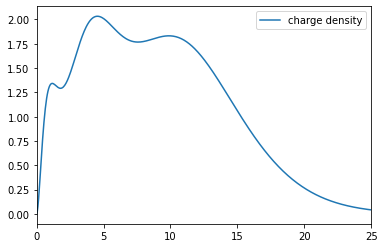

In [23]:
%matplotlib inline

Esearch = -1.2/arange(1,20,0.2)**2
R = linspace(1e-8,100,2000)

Z=28
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)

z = 28. # like Ni atom

rho = ChargeDensity(Bnd,R,Z)
        
plot(R, rho*(4*pi*R**2), label='charge density')
xlim([0,25])
legend(loc='best')
show()

## Hartree term

The Hartree term is treated exactly in this approximation. 

It describes the electrostatic
interaction of one electron with the cloud of all electrons (including the electron itself).
Mathematically, this term is
\begin{eqnarray}
&&   \frac{1}{2}\int d\vec{r} d\vec{r}' \psi^\dagger (\vec{r})\psi^\dagger (\vec{r}')
   v_c(\vec{r}-\vec{r}') \psi(\vec{r}')\psi(\vec{r}) \rightarrow\\
&&   \int d\vec{r} \psi^\dagger(\vec{r}) \psi(\vec{r}) \int d\vec{r}'
   \langle\psi^\dagger(\vec{r}') \psi(\vec{r}')\rangle v_c(\vec{r}-\vec{r}') \equiv
   \int d\vec{r} \psi^\dagger(\vec{r}) V_{H}(\vec{r}) \psi(\vec{r})\nonumber
 \end{eqnarray}
 with
 \begin{equation}
 V_H(\vec{r}) = 2 \int d\vec{r}' \frac{\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}
 \end{equation}
where $2$ is due to Rydberg units sinc $v_c = 2/r$.


For any atom, the electron density is
spherically symetric and hence $V_{H}$ depends only on radial
distance. (In solids, the hartree potential should be expanded in
spheric harmonics to sufficiently high $l$, maybe $l=6$).

### Step 1: Using $\rho(r)$ computed in previous homework, compute the Hartree potential.

This is usually achieved by solving the Poisson equation. From
clasical electrostatic we know
\begin{eqnarray}
  \nabla^2 V_{H}(\vec{r}) = -8\pi \rho(\vec{r})
\end{eqnarray}
In Hartree approximation, we have
\begin{equation}
\frac{1}{r^2}\frac{d}{dr}(r^2 \frac{d V_H}{dr})= -8\pi\rho(r)  
\end{equation}
which simplifies to
\begin{equation}
  U^{''}(r) = -8\pi r \rho(r)
\end{equation}
where $U(r) = V_{H}(r) r$.

This second order differential equation has the following boundary
conditions $U(0)=0$ and $U(\infty)=2 Z$.

The two point boundary problem does not require shooting because we
know solution to the homogenous differential equation
$U^{''}(r)=0$. The Hartree potential can be obtained from any
particular solution by
\begin{equation}
  U(r) = U_p(r) + \alpha r
\end{equation}
where $\alpha = \lim_{r\rightarrow\infty}(2 Z-U_{p}(r))/r$.


In [24]:
def FuncForHartree(y,r,rhoSpline):
    """ y = [U,U']
        dy/dr = [U', -8*pi*r*rho(r)]
    """
    return [y[1], -8*pi*r*rhoSpline(r)]

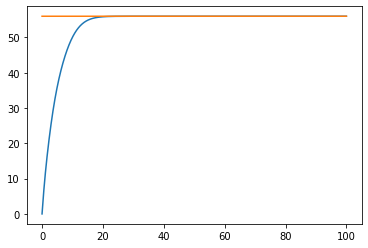

In [25]:
from scipy import interpolate

rhoSpline = interpolate.UnivariateSpline(R, rho,s=0)

U0 = integrate.odeint(FuncForHartree, [0.0,0.5], R, args=(rhoSpline,))[:,0]
alpha = (2*Z - U0[-1])/R[-1]
U0 += alpha * R

plot(R, U0)
plot(R, ones(len(R))*2*Z)
show()

## Numerov again

Poisson equation does not have the first order derivative, hence it can also be more efficiently solved by the Numerov algorithm.

We have Poisson equation, which has the form
\begin{equation}
x^{''}(t)= u(t)
\end{equation}
and the Numerov algorithm, as appropriate for the Poisson equation, is
\begin{eqnarray}
  x(h)+x(-h) = 2x(0)+h^2 u(0)+\frac{2}{4!}h^4 x^{(4)}(0)+O(h^6)
\end{eqnarray}
and the approximation for the forth order derivative is
\begin{equation}
  x^{(4)}\sim \frac{u_{i+1}-2 u_i+u_{i-1}}{h^2}
\end{equation}

Inserting the fourth order derivative into the above recursive equation (forth equation in his chapter), we
get

\begin{equation}
  x_{i+1}-2 x_i+x_{i-1}=h^2 u_i +\frac{h^2}{12}(u_{i+1}-2 u_i+u_{i-1})
\end{equation}

If we switch to a new variable $w_i=x_i-\frac{h^2}{12}u_i$
we are left with the following
equation

\begin{equation}
  w_{i+1} -2 w_i + w_{i-1} = h^2 u_i+O(h^6)
\end{equation}

The variable $x$ needs to be recomputed at each step with
$x_i=(w_i+\frac{h^2}{12}u_i)$.


In [26]:
@jit(nopython=True)
def NumerovUP(U, x0, dx, dh):
    x = zeros(len(U))
    x[0] = x0
    x[1] = dh*dh + x0
    h2 = dh*dh
    h12 = h2/12
    w0 = x[0]-h12*U[0]
    w1 = x[1]-h12*U[1]
    Ui = U[1]
    for i in range(2,len(U)):
        w2 = 2*w1 - w0 + h2*Ui
        Ui = U[i]
        xi = w2 + h12*Ui
        x[i] = xi
        w0, w1 = w1, w2
    return x

In [27]:
ux = -8*pi*R*rho
U2 = NumerovUP(ux, 0.0, 0.5, R[1]-R[0])
alpha2 = (2*Z-U2[-1])/R[-1]
U2 += alpha2 * R

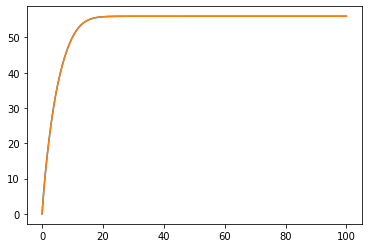

In [28]:
plot(R,U0)
plot(R,U2);

### Step1 routine HartreeU  
For generic density the following routine will work:

In [29]:
def HartreeU(R, rho, Zatom):
    """Given input charge density it returns Hartree potential in the form VH(r)*r
    """
    ux = -8*pi*R*rho
    U2 = NumerovUP(ux, 0.0, 0.5, R[1]-R[0])
    alpha2 = (2*Zatom-U2[-1])/R[-1]
    U2 += alpha2 * R
    return U2

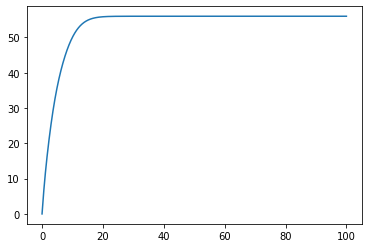

In [30]:
U2 = HartreeU(R,rho,Z)
plot(R,U2);

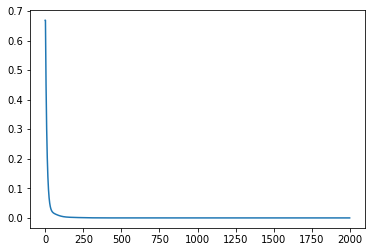

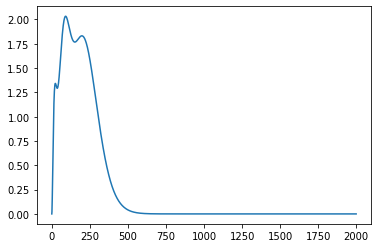

In [31]:
plt.plot(rho)
plt.show()

plt.plot(rho * (4 * R**2 * np.pi))
plt.show()

### Step 2 : Compute the exchange correlation potential.
   
Note that $V_{xc}(r)=V_{xc}(\rho(r))$ is unquely determined by the electron charge density $\rho(r)$. If we know $\rho$, we can instantly compute $V_{xc}$ by the module provided parametrized function.
   

Download the module `excor.py` from
http://www.physics.rutgers.edu/~haule/509/src_prog/python/homework5/
and import it in your code.


Instantiate the ExchangeCorrelation object by

`exc = ExchangeCorrelation()`

and used it, for example, by

`exc.Vx(rs(rho[i]))+exc.Vc(rs(rho[i]))`

where $r_s = ({4\pi\rho/3})^{-1/3}$.

Be careful: The energy unit in "excor.py" is Hartree and not
Rydergs. Hence, you need to multiply energy or potential by 2.



In [68]:
from excor import ExchangeCorrelation
exc = ExchangeCorrelation()

@jit(nopython=True)
def rs(rho):
    "1/rho = 4*pi*rs^3/3 => rs = (3/(4*pi*rho))**(1/3.)"
    if rho < 1e-100: return 1e100
    return pow(3/(4*pi*rho),1/3.)

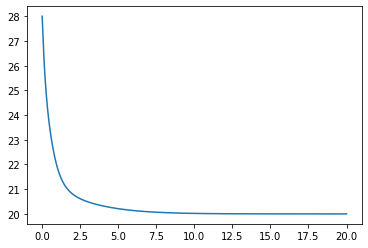

In [69]:
Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]    

Uks = U2 - 2*Z + Vxc*R

plot(R, -Uks/2);


### Step 3: Find bound states using Hartree and XC potential.

Add the Hartree potential and the exchange-correlation potential to the Schroedinger equation and find
  bound states of the atom.

The Schroedinger equation is
 \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}-\frac{2 Z}{r} + V_{H}(r)+V_{XC}(r)-\varepsilon\right)u(r).
 \end{equation}
or
  \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}+\frac{U_H - 2 Z +r V_{XC}}{r}-\varepsilon\right)u(r).
 \end{equation}

In [77]:
@jit(nopython=True)
def fShrod(En,l,R, Uks):
    return (l*(l+1.)/R +Uks)/R - En

def ComputeSchrod(En, R, l,Uks):
    f = fShrod(En,l,R[::-1],Uks[::-1])
    print(f[0:10])
    print(R[0] - R[1])
    ur = Numerov(f, 0.0, -1e-10, R[0]-R[1])[::-1]
    print(ur[0:10])
    norm = integrate.simps(ur**2, x=R)
    return ur/sqrt(abs(norm))

def Shoot(En, R, l, Uks):
    ur = ComputeSchrod(En, R, l,Uks)
    ur *= 1/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    poly = polyfit(R[:4], ur[:4], deg=3)
    return polyval(poly, 0.0)

In [78]:
def FindBoundStates(R, l, nmax, Esearch, Uks):
    
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l,Uks)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l,Uks)
        if u0*u1 < 0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l,Uks))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

In [79]:
#R = linspace(1e-8,10,2**13+1)
#Zatom = 8
#E0=-1.2*Zatom**2
#Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
#Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift


Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
Bnd = sorted(Bnd, key=cmpKey)

[76.8        76.79999979 76.79999967 76.79999956 76.79999947 76.79999939
 76.79999931 76.79999923 76.79999916 76.79999909]
-0.0012207031243896484
[1.86163002e+61 4.22312788e+63 4.65701457e+63 5.04413901e+63
 5.39872018e+63 5.72759997e+63 6.03492201e+63 6.32350914e+63
 6.59543187e+63 6.85228863e+63]
E & Uks:  -76.80000000000001 -15.999999692914328
0.004209692166100343
[71.70888721 71.708887   71.70888687 71.70888677 71.70888668 71.70888659
 71.70888651 71.70888644 71.70888637 71.7088863 ]
-0.0012207031243896484
[4.61793221e+58 1.05666849e+61 1.17321485e+61 1.27797963e+61
 1.37449230e+61 1.46445244e+61 1.54889031e+61 1.62850856e+61
 1.70382319e+61 1.77523311e+61]
[66.95308398 66.95308377 66.95308365 66.95308354 66.95308345 66.95308337
 66.95308329 66.95308321 66.95308314 66.95308307]
-0.0012207031243896484
[1.37766510e+56 3.18511180e+58 3.56496068e+58 3.90901238e+58
 4.22780493e+58 4.52641733e+58 4.80793191e+58 5.07445356e+58
 5.32753041e+58 5.56836114e+58]
[62.51050625 62.51050604 62.51

[1.32302742 1.32302721 1.32302709 1.32302699 1.32302689 1.32302681
 1.32302673 1.32302665 1.32302658 1.32302651]
-0.0012207031243896484
[ 1.29241018e-05  2.08995573e-03  1.56399998e-03  1.02143564e-03
  4.71913952e-04 -8.00333369e-05 -6.31744625e-04 -1.18147201e-03
 -1.72798666e-03 -2.27038435e-03]
[1.20295966 1.20295945 1.20295932 1.20295922 1.20295913 1.20295904
 1.20295896 1.20295889 1.20295882 1.20295875]
-0.0012207031243896484
[ 6.17521293e-06  1.08061446e-03  9.09867290e-04  7.29604451e-04
  5.44456214e-04  3.56606799e-04  1.67346775e-04 -2.24700000e-05
 -2.12237833e-04 -4.01506304e-04]
[1.09079977 1.09079956 1.09079943 1.09079933 1.09079924 1.09079915
 1.09079907 1.090799   1.09079893 1.09079886]
-0.0012207031243896484
[2.82898953e-06 5.18172639e-04 4.62658692e-04 4.02339998e-04
 3.39343085e-04 2.74673922e-04 2.08929053e-04 1.42504917e-04
 7.56842222e-05 8.67849177e-06]
[0.98602692 0.98602671 0.98602659 0.98602648 0.98602639 0.9860263
 0.98602623 0.98602615 0.98602608 0.98602601

[-6.21611930e+00  4.83520144e+09  2.30680827e+09  1.54672314e+09
  1.17071705e+09  9.45760781e+08  7.96015345e+08  6.89187139e+08
  6.09167140e+08  5.47014962e+08]
[4.57054091 4.57054131 4.57054179 4.5705423  4.57054282 4.57054335
 4.57054388 4.57054441 4.57054495 4.5705455 ]
-0.0012207031243896484
[-1.20623155e+00  9.38266173e+08  4.47634495e+08  3.00141288e+08
  2.27178337e+08  1.83526555e+08  1.54469462e+08  1.33740514e+08
  1.18213770e+08  1.06154354e+08]
[4.23691555 4.23691595 4.23691644 4.23691694 4.23691746 4.23691799
 4.23691852 4.23691906 4.2369196  4.23692014]
-0.0012207031243896484
[-2.45349710e-01  1.90845121e+08  9.10498199e+07  6.10495381e+07
  4.62088703e+07  3.73301712e+07  3.14200803e+07  2.72039710e+07
  2.40460204e+07  2.15933513e+07]
[3.92526334 3.92526374 3.92526423 3.92526473 3.92526525 3.92526578
 3.92526631 3.92526685 3.92526739 3.92526793]
-0.0012207031243896484
[-5.22005246e-02  4.06041581e+07  1.93717596e+07  1.29889321e+07
  9.83146430e+06  7.94246809e+06  6


### Step 4: Compute the new electron density
by filling the lowest $Z$  eigenstatates.

In [80]:
# This is modified from Hydrogen
def ChargeDensity(bst,R,Zatom,Uks):
    rho = zeros(len(R))
    N=0.
    Ebs=0.
    for (l,En) in bst:
        ur = ComputeSchrod(En, R, l, Uks)
        dN = 2*(2*l+1)
        if N+dN <= Zatom:
            ferm = 1.
        else:
            ferm = (Zatom-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*pi*R**2)
        rho += drho
        N += dN
        Ebs += En * dN * ferm
        print('adding state', (l,En/2), 'H with fermi=', ferm)
        if  N>=Zatom: break
    return (rho,Ebs)

In [81]:
rho_new, Ebs = ChargeDensity(Bnd,R,Z,Uks)

[37.51648981 37.5164896  37.51648948 37.51648937 37.51648928 37.5164892
 37.51648912 37.51648904 37.51648897 37.5164889 ]
-0.0012207031243896484
[3.26821737e+34 3.95079272e+39 7.82479045e+39 1.16231708e+40
 1.53470643e+40 1.89975875e+40 2.25758426e+40 2.60829178e+40
 2.95198874e+40 3.28878120e+40]
adding state (0, -18.758244905273884) H with fermi= 1.0
[1.74272429 1.74272408 1.74272396 1.74272385 1.74272376 1.74272368
 1.7427236  1.74272352 1.74272345 1.74272338]
-0.0012207031243896484
[-1.45238576e-07 -1.75570390e-02 -3.47718726e-02 -5.16488253e-02
 -6.81920367e-02 -8.44056062e-02 -1.00293594e-01 -1.15860019e-01
 -1.31108861e-01 -1.46044061e-01]
adding state (0, -0.8713621453900082) H with fermi= 1.0
[0.68176158 0.68176198 0.68176246 0.68176297 0.68176349 0.68176402
 0.68176455 0.68176508 0.68176562 0.68176617]
-0.0012207031243896484
[5.38217441e-19 7.98114597e-09 3.17690430e-08 7.11328064e-08
 1.25844246e-07 1.95677846e-07 2.80410739e-07 3.79822689e-07
 4.93696066e-07 6.21815821e-07]

### Step 5: Admix the new and the old density 
(50\% of the old and 50\%  of the new should work) and use the resulting density to compute the  new Hartree and exchange-correlation potential.

### Iterate Steps 1 to Step 5 until self-consistency is achieved.

For oxygen, the total energy in this implementation is : -74.47303426133809 Hartree, while NIST shows -74.473077 Hartree. This is in excellent agreement. The small loss of accuracy is mainly due to the mesh used for R.

### Evaluate the total energy

Once we see that the code converges, we can insert a new step
betwen *Step 4* and *Step 5* to compute the total energy of
the system. The total energy can be obtained by
\begin{eqnarray}
E^{LDA}_{total} &=& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2]\psi_i(\vec{r}) +\nonumber\\
 &+& \int d\vec{r} \rho(\vec{r}) [V_{nucleous}(\vec{r})+\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2+V_{nucleous}+V_H+V_{XC}]\psi_i(\vec{r})
 \nonumber\\
 &+& \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [-\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]
\end{eqnarray}
Here we used
\begin{eqnarray}
&& E_y[\rho] \equiv \int d\vec{r}\; \rho(\vec{r})\; \epsilon_y[\rho(\vec{r})]\\
&& V_y[\rho]\equiv \frac{\delta E_y[\rho]}{\delta \rho(\vec{r})}
\end{eqnarray}
where $y$ is one of $H$, $x$ or $c$. 

Hence
\begin{eqnarray}
\epsilon_H(\vec{r}) = \frac{1}{2} V_H(\vec{r})  = \frac{1}{2} \frac{U_H(\vec{r})}{r}
\end{eqnarray}
because
\begin{equation}
E_H = \int d\vec{r} d\vec{r}' \frac{\rho(\vec{r})\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}
\end{equation}

The exchange-correlation energy can be obtained by a call to the
 method of \textit{ExchangeCorrelation} object.


(-1.0, 1.0)

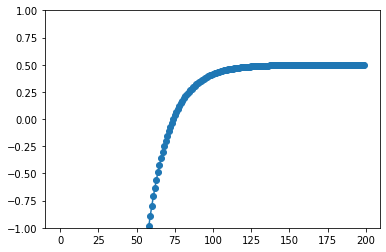

In [82]:
Zatom=8
E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift
plot(Esearch,'o-')
ylim([-1,1])

[76.7        76.6999939  76.69998779 76.69998169 76.69997558 76.69996947
 76.69996337 76.69995726 76.69995115 76.69994504]
-0.0012207031243896484
[1.38089815e+63 3.56418976e+64 3.55355437e+64 3.53874564e+64
 3.52140142e+64 3.50228660e+64 3.48185033e+64 3.46038879e+64
 3.43811201e+64 3.41517656e+64]
E & Uks:  -76.80000000000001 -2.0
0.14378126756328147
[71.60888721 71.6088811  71.608875   71.60886889 71.60886279 71.60885668
 71.60885057 71.60884446 71.60883835 71.60883224]
-0.0012207031243896484
[3.79387125e+60 9.79672231e+61 9.77191370e+61 9.73555534e+61
 9.69214786e+61 9.64379368e+61 9.59172768e+61 9.53676459e+61
 9.47948241e+61 9.42031226e+61]
[66.85308398 66.85307788 66.85307177 66.85306567 66.85305956 66.85305345
 66.85304734 66.85304124 66.85303513 66.85302902]
-0.0012207031243896484
[1.26786502e+58 3.27540854e+59 3.26855803e+59 3.25782133e+59
 3.24470277e+59 3.22990521e+59 3.21384162e+59 3.19678457e+59
 3.17892750e+59 3.16041478e+59]
[62.41050625 62.41050014 62.41049404 62.410487

[0.14981915 0.14981305 0.14980694 0.14980084 0.14979473 0.14978862
 0.14978252 0.14977641 0.1497703  0.14976419]
-0.0012207031243896484
[ 1.89758381e-13 -1.43050453e-11 -3.34800456e-11 -5.26145224e-11
 -7.17062844e-11 -9.07543406e-11 -1.09758134e-10 -1.28717317e-10
 -1.47631660e-10 -1.66501010e-10]
[0.14997424 0.14996814 0.14996203 0.14995593 0.14994982 0.14994371
 0.14993761 0.1499315  0.14992539 0.14991928]
-0.0012207031243896484
[-1.74933360e-16 -1.93421195e-11 -3.86364452e-11 -5.78836219e-11
 -7.70837143e-11 -9.62367875e-11 -1.15342906e-10 -1.34402134e-10
 -1.53414537e-10 -1.72380178e-10]
[0.14997423 0.14996812 0.14996202 0.14995591 0.14994981 0.1499437
 0.14993759 0.14993149 0.14992538 0.14991927]
-0.0012207031243896484
[-1.58639001e-16 -1.93416874e-11 -3.86360029e-11 -5.78831699e-11
 -7.70832531e-11 -9.62363172e-11 -1.15342427e-10 -1.34401647e-10
 -1.53414041e-10 -1.72379674e-10]
[0.14997423 0.14996812 0.14996202 0.14995591 0.14994981 0.1499437
 0.14993759 0.14993149 0.14992538 0

[4.47054091 4.47053541 4.47052992 4.47052442 4.47051893 4.47051343
 4.47050794 4.47050244 4.47049694 4.47049144]
-0.0012207031243896484
[-6.19964480e+00  4.79428181e+09  2.26639448e+09  1.50639375e+09
  1.13025996e+09  9.05084914e+08  7.55072687e+08  6.47948685e+08
  5.67613619e+08  5.05132664e+08]
[4.13691555 4.13691006 4.13690456 4.13689907 4.13689357 4.13688808
 4.13688258 4.13687708 4.13687158 4.13686608]
-0.0012207031243896484
[-1.28167222e+00  9.91137315e+08  4.68539390e+08  3.11422264e+08
  2.33663172e+08  1.87112262e+08  1.56100000e+08  1.33954159e+08
  1.17346480e+08  1.04429840e+08]
[3.82526334 3.82525785 3.82525235 3.82524686 3.82524136 3.82523587
 3.82523037 3.82522487 3.82521937 3.82521388]
-0.0012207031243896484
[-2.77228191e-01  2.14384976e+08  1.01346076e+08  6.73613844e+07
  5.05419899e+07  4.04729862e+07  3.37650228e+07  2.89748835e+07
  2.53826598e+07  2.25888150e+07]
[3.53413709 3.53413159 3.5341261  3.53412061 3.53411511 3.53410961
 3.53410412 3.53409862 3.53409312

[-0.11117337 -0.11117886 -0.11118435 -0.11118985 -0.11119534 -0.11120084
 -0.11120634 -0.11121183 -0.11121733 -0.11122283]
-0.0012207031243896484
[6.22913642e-26 1.80563119e-16 8.51799458e-16 1.94298875e-15
 3.46398262e-15 5.41577859e-15 7.79816638e-15 1.06106017e-14
 1.38524166e-14 1.75228887e-14]
[-0.11117337 -0.11117886 -0.11118435 -0.11118985 -0.11119534 -0.11120084
 -0.11120634 -0.11121183 -0.11121733 -0.11122283]
-0.0012207031243896484
[1.46006618e-26 2.17443205e-16 8.69233918e-16 1.95457704e-15
 3.47267762e-15 5.42274156e-15 7.80397551e-15 1.06155869e-14
 1.38567840e-14 1.75267756e-14]
[-0.11117337 -0.11117886 -0.11118435 -0.11118985 -0.11119534 -0.11120084
 -0.11120634 -0.11121183 -0.11121733 -0.11122283]
-0.0012207031243896484
[3.89733448e-26 1.98595366e-16 8.60323909e-16 1.94865476e-15
 3.46823397e-15 5.41918308e-15 7.80100672e-15 1.06130392e-14
 1.38545520e-14 1.75247892e-14]
[-0.11117337 -0.11117886 -0.11118435 -0.11118985 -0.11119534 -0.11120084
 -0.11120634 -0.11121183 -0

[1.51095375e+47 1.82651825e+52 3.61752085e+52 5.37354012e+52
 7.09508661e+52 8.78266425e+52 1.04367704e+53 1.20578961e+53
 1.36465258e+53 1.52031379e+53]
Found bound state at E= -58.810318070
[54.48386765 54.48376375 54.4837031  54.48365238 54.48360719 54.48356574
 54.48352703 54.48349047 54.48345566 54.48342231]
-0.0012207031243896484
[-5.06607287e+47 -5.34536588e+49 -4.87690409e+48  4.38023431e+49
  9.22142813e+49  1.40189784e+50  1.87632960e+50  2.34483649e+50
  2.80701933e+50  3.26260522e+50]
[50.86253425 50.86243035 50.8623697  50.86231897 50.86227379 50.86223233
 50.86219363 50.86215707 50.86212226 50.86208891]
-0.0012207031243896484
[-6.23267331e+45 -9.81603693e+47 -7.02178979e+47 -4.15275482e+47
 -1.25531071e+47  1.64885293e+47  4.54706397e+47  7.43105480e+47
  1.02950588e+48  1.31348726e+48]
[47.47970818 47.47960428 47.47954363 47.4794929  47.47944772 47.47940626
 47.47936756 47.479331   47.47929619 47.47926284]
-0.0012207031243896484
[-6.99208718e+43 -1.23281330e+46 -1.048600

[54.48886765 54.48876437 54.48870432 54.48865421 54.48860964 54.48856879
 54.4885307  54.48849475 54.48846055 54.48842781]
-0.0012207031243896484
[-4.10658694e+44  3.19424256e+53  1.52382790e+53  1.02160981e+53
  7.73118610e+52  6.24407602e+52  5.25375329e+52  4.54687882e+52
  4.01703398e+52  3.60515839e+52]
[50.86753425 50.86743096 50.86737092 50.86732081 50.86727623 50.86723539
 50.86719729 50.86716135 50.86712715 50.86709441]
-0.0012207031243896484
[-2.70760172e+42  2.10607036e+51  1.00471984e+51  6.73598574e+50
  5.09767907e+50  4.11725895e+50  3.46439029e+50  2.99841159e+50
  2.64915740e+50  2.37768711e+50]
[47.48470818 47.48460489 47.48454485 47.48449474 47.48445016 47.48440932
 47.48437122 47.48433528 47.48430108 47.48426834]
-0.0012207031243896484
[-2.09893801e+40  1.63263407e+49  7.78869665e+48  5.22188875e+48
  3.95192465e+48  3.19195887e+48  2.68591472e+48  2.32475086e+48
  2.05407471e+48  1.84369922e+48]
[44.32468093 44.32457765 44.32451761 44.32446749 44.32442292 44.324382

Total density has weight 8.0
Itteration 1 Etot[Ry]= -224.73766490892288 Etot[Hartre]= -112.36883245446144 Diff= 208.01161350933714
[76.8        76.79991746 76.79986924 76.7998289  76.79979295 76.79975997
 76.79972917 76.79970007 76.79967236 76.79964581]
-0.0012207031243896484
[8.70986773e+60 2.00757665e+63 2.24171700e+63 2.45333890e+63
 2.64910240e+63 2.83221629e+63 3.00462705e+63 3.16766328e+63
 3.32230160e+63 3.46929776e+63]
E & Uks:  -76.80000000000001 -15.99999980123753
0.0034276564929776043
[71.70888721 71.70880466 71.70875644 71.7087161  71.70868016 71.70864718
 71.70861638 71.70858728 71.70855957 71.70853302]
-0.0012207031243896484
[2.04790801e+58 4.78333743e+60 5.39573006e+60 5.95393370e+60
 6.47362409e+60 6.96236245e+60 7.42474205e+60 7.86390327e+60
 8.28215893e+60 8.68130236e+60]
[66.95308398 66.95300144 66.95295322 66.95291288 66.95287693 66.95284395
 66.95281315 66.95278405 66.95275634 66.95272979]
-0.0012207031243896484
[5.72751866e+55 1.36094484e+58 1.55495414e+58 1.73335

[0.77881171 0.77872917 0.77868095 0.77864061 0.77860467 0.77857168
 0.77854088 0.77851179 0.77848408 0.77845753]
-0.0012207031243896484
[2.80164881e-12 3.38673848e-07 6.70740634e-07 9.96277981e-07
 1.31536008e-06 1.62806051e-06 1.93445220e-06 2.23460748e-06
 2.52859804e-06 2.81649495e-06]
Found bound state at E=  -0.778811713
[0.63154365 0.6314611  0.63141288 0.63137254 0.6313366  0.63130361
 0.63127281 0.63124372 0.63121601 0.63118946]
-0.0012207031243896484
[-1.97695619e-09 -3.61221513e-07 -3.21549342e-07 -2.78531258e-07
 -2.33653893e-07 -1.87620834e-07 -1.40849574e-07 -9.36177786e-08
 -4.61236388e-08  1.48439553e-09]
[0.55701821 0.55693566 0.55688745 0.5568471  0.55681116 0.55677818
 0.55674738 0.55671828 0.55669057 0.55666402]
-0.0012207031243896484
[-1.21515703e-09 -2.37314233e-07 -2.27941923e-07 -2.16218052e-07
 -2.03059649e-07 -1.88902462e-07 -1.74006375e-07 -1.58545309e-07
 -1.42644311e-07 -1.26397830e-07]
[0.48740115 0.4873186  0.48727038 0.48723004 0.4871941  0.48716111
 0.48

[0.55279329 0.55271136 0.55266375 0.55262402 0.55258869 0.55255632
 0.55252613 0.55249764 0.55247054 0.5524446 ]
-0.0012207031243896484
[ 1.85410390e-21 -9.71484530e-11 -3.64934340e-10 -8.12454387e-10
 -1.43532139e-09 -2.23065427e-09 -3.19580074e-09 -4.32819118e-09
 -5.62530320e-09 -7.08464991e-09]
[0.55279327 0.55271134 0.55266373 0.552624   0.55258866 0.55255629
 0.5525261  0.55249762 0.55247052 0.55244458]
-0.0012207031243896484
[-6.13266453e-21 -9.09358517e-11 -3.61970181e-10 -8.10466602e-10
 -1.43381644e-09 -2.22943801e-09 -3.19477650e-09 -4.32730375e-09
 -5.62451808e-09 -7.08394410e-09]
[0.55279327 0.55271134 0.55266373 0.552624   0.55258866 0.55255629
 0.5525261  0.55249762 0.55247052 0.55244458]
-0.0012207031243896484
[-6.13253972e-21 -9.09359488e-11 -3.61970227e-10 -8.10466633e-10
 -1.43381646e-09 -2.22943803e-09 -3.19477651e-09 -4.32730376e-09
 -5.62451809e-09 -7.08394411e-09]
[0.55279327 0.55271134 0.55266373 0.552624   0.55258866 0.55255629
 0.5525261  0.55249762 0.55247052

[66.95308398 66.95301841 66.95298008 66.952948   66.95291942 66.95289318
 66.95286868 66.95284553 66.95282348 66.95280235]
-0.0012207031243896484
[1.02714472e+56 2.38912663e+58 2.68646900e+58 2.95683429e+58
 3.20808273e+58 3.44400457e+58 3.66690140e+58 3.87834610e+58
 4.07949646e+58 4.27124970e+58]
[62.51050625 62.51044067 62.51040235 62.51037027 62.51034169 62.51031545
 62.51029095 62.5102678  62.51024575 62.51022462]
-0.0012207031243896484
[3.57938840e+53 8.44811965e+55 9.60457462e+55 1.06646199e+56
 1.16556790e+56 1.25909931e+56 1.34786153e+56 1.43240596e+56
 1.51313930e+56 1.59037742e+56]
[58.36052443 58.36045886 58.36042053 58.36038845 58.36035987 58.36033363
 58.36030913 58.36028598 58.36026393 58.3602428 ]
-0.0012207031243896484
[1.46407727e+51 3.52187013e+53 4.06003257e+53 4.55746922e+53
 5.02541495e+53 5.46930360e+53 5.89244710e+53 6.29711848e+53
 6.68499891e+53 7.05739790e+53]
[54.48386765 54.48380208 54.48376375 54.48373167 54.48370309 54.48367685
 54.48365235 54.4836292  54

[0.26707733 0.26701176 0.26697343 0.26694135 0.26691277 0.26688653
 0.26686203 0.26683888 0.26681683 0.2667957 ]
-0.0012207031243896484
[5.04017329e-15 6.14735515e-10 1.21749382e-09 1.80841299e-09
 2.38763377e-09 2.95529565e-09 3.51153682e-09 4.05649419e-09
 4.59030339e-09 5.11309876e-09]
[0.26707747 0.26701189 0.26697357 0.26694149 0.26691291 0.26688667
 0.26686217 0.26683902 0.26681697 0.26679584]
-0.0012207031243896484
[5.08542667e-15 6.14746628e-10 1.21750682e-09 1.80842775e-09
 2.38765019e-09 2.95531364e-09 3.51155632e-09 4.05651514e-09
 4.59032573e-09 5.11312243e-09]
[0.26707747 0.26701189 0.26697357 0.26694149 0.26691291 0.26688667
 0.26686217 0.26683902 0.26681697 0.26679584]
-0.0012207031243896484
[5.08542668e-15 6.14746628e-10 1.21750682e-09 1.80842775e-09
 2.38765019e-09 2.95531364e-09 3.51155632e-09 4.05651514e-09
 4.59032573e-09 5.11312243e-09]
[0.26707747 0.26701189 0.26697357 0.26694149 0.26691291 0.26688667
 0.26686217 0.26683902 0.26681697 0.26679584]
-0.00122070312438

Found bound state at E=  -1.415419295
[1.20795966 1.2078947  1.20785698 1.20782551 1.20779754 1.20777191
 1.20774802 1.20772548 1.20770405 1.20768353]
-0.0012207031243896484
[ 6.87745546e-11 -5.34961581e-02 -2.55215995e-02 -1.71108154e-02
 -1.29488384e-02 -1.04574622e-02 -8.79761877e-03 -7.61202210e-03
 -6.72245101e-03 -6.02999749e-03]
[1.09579977 1.0957348  1.09569709 1.09566562 1.09563765 1.09561202
 1.09558813 1.09556559 1.09554415 1.09552363]
-0.0012207031243896484
[ 3.82850889e-11 -2.97800580e-02 -1.42075169e-02 -9.52577695e-03
 -7.20937264e-03 -5.82307847e-03 -4.89980398e-03 -4.24065509e-03
 -3.74641860e-03 -3.36203304e-03]
[0.99102692 0.99096196 0.99092424 0.99089277 0.9908648  0.99083918
 0.99081528 0.99079274 0.99077131 0.99075079]
-0.0012207031243896484
[ 1.87490633e-11 -1.45839773e-02 -6.95780347e-03 -4.66512915e-03
 -3.53084276e-03 -2.85208180e-03 -2.40010118e-03 -2.07749759e-03
 -1.83568367e-03 -1.64769416e-03]
[0.89315459 0.89308963 0.89305192 0.89302045 0.89299248 0.8929

E & Uks:  -76.80000000000001 -15.99999970490661
0.004144181740056485
[71.70888721 71.70883512 71.70880466 71.70877916 71.70875643 71.70873557
 71.70871608 71.70869767 71.70868013 71.70866332]
-0.0012207031243896484
[4.07474325e+58 9.33778555e+60 1.03799140e+61 1.13177992e+61
 1.21825875e+61 1.29892787e+61 1.37469668e+61 1.44618549e+61
 1.51384997e+61 1.57804242e+61]
[66.95308398 66.9530319  66.95300143 66.95297593 66.95295321 66.95293234
 66.95291285 66.95289444 66.9528769  66.95286009]
-0.0012207031243896484
[1.20792461e+56 2.79796624e+58 3.13620420e+58 3.44294911e+58
 3.72744179e+58 3.99413672e+58 4.24573769e+58 4.48409151e+58
 4.71055682e+58 4.92618589e+58]
[62.51050625 62.51045416 62.5104237  62.5103982  62.51037547 62.51035461
 62.51033512 62.51031671 62.51029917 62.51028235]
-0.0012207031243896484
[4.26199398e+53 1.00039416e+56 1.13266754e+56 1.25357042e+56
 1.36636677e+56 1.47263181e+56 1.57332306e+56 1.66909566e+56
 1.76043248e+56 1.84770828e+56]
[58.36052443 58.36047234 58.360

 1.58898494 1.58896653 1.58894899 1.58893218]
-0.0012207031243896484
[ 5.17591227e-05  8.29516914e-03  6.11532252e-03  3.87039312e-03
  1.59901886e-03 -6.80665293e-04 -2.95801393e-03 -5.22604076e-03
 -7.47983817e-03 -9.71579844e-03]
[1.45156061 1.45150852 1.45147806 1.45145256 1.45142984 1.45140897
 1.45138948 1.45137107 1.45135353 1.45133672]
-0.0012207031243896484
[ 2.38722543e-05  4.19390151e-03  3.54996697e-03  2.86892488e-03
  2.16867982e-03  1.45768041e-03  7.40920570e-04  2.17059542e-05
 -6.97617182e-04 -1.41530288e-03]
[1.32302742 1.32297534 1.32294488 1.32291938 1.32289665 1.32287579
 1.3228563  1.32283788 1.32282034 1.32280353]
-0.0012207031243896484
[1.03899208e-05 1.91793432e-03 1.72864436e-03 1.52141946e-03
 1.30407335e-03 1.08030437e-03 8.52307172e-04 6.21541474e-04
 3.89049256e-04 1.55611049e-04]
[1.20295966 1.20290757 1.20287711 1.20285161 1.20282889 1.20280802
 1.20278853 1.20277012 1.20275258 1.20273577]
-0.0012207031243896484
[4.39642394e-06 8.37533549e-04 7.82945988

[15.63506566 15.63501419 15.63498434 15.63495945 15.63493733 15.63491708
 15.6348982  15.6348804  15.63486347 15.63484727]
-0.0012207031243896484
[-4.77826103e+15  3.71673536e+24  1.77315271e+24  1.18884197e+24
  8.99762275e+23  7.26787017e+23  6.11619874e+23  5.29437341e+23
  4.67856784e+23  4.20006007e+23]
[14.57271141 14.57265994 14.57263009 14.5726052  14.57258308 14.57256283
 14.57254395 14.57252615 14.57250922 14.57249302]
-0.0012207031243896484
[-3.13715096e+14  2.44021199e+23  1.16416176e+23  7.80537163e+22
  5.90745782e+22  4.77182634e+22  4.01573449e+22  3.47620425e+22
  3.07193777e+22  2.75781575e+22]
[13.58032566 13.58027419 13.58024434 13.58021945 13.58019733 13.58017708
 13.5801582  13.5801404  13.58012347 13.58010727]
-0.0012207031243896484
[-2.24755002e+13  1.74824321e+22  8.34043726e+21  5.59205226e+21
  4.23234912e+21  3.41876997e+21  2.87710623e+21  2.49059543e+21
  2.20099323e+21  1.97597474e+21]
[12.65330017 12.6532487  12.65321885 12.65319396 12.65317184 12.653151

[-0.04902354 -0.04907501 -0.04910486 -0.04912975 -0.04915187 -0.04917212
 -0.049191   -0.0492088  -0.04922573 -0.04924193]
-0.0012207031243896484
[2.68477841e-25 3.98123893e-15 1.58473496e-14 3.54831208e-14
 6.27746567e-14 9.76093687e-14 1.39875965e-13 1.89464440e-13
 2.46266064e-13 3.10173370e-13]
[-0.04902354 -0.04907501 -0.04910486 -0.04912975 -0.04915187 -0.04917212
 -0.049191   -0.0492088  -0.04922573 -0.04924193]
-0.0012207031243896484
[2.68479724e-25 3.98123746e-15 1.58473489e-14 3.54831203e-14
 6.27746563e-14 9.76093684e-14 1.39875965e-13 1.89464440e-13
 2.46266064e-13 3.10173370e-13]
[-0.04902354 -0.04907501 -0.04910486 -0.04912975 -0.04915187 -0.04917212
 -0.049191   -0.0492088  -0.04922573 -0.04924193]
-0.0012207031243896484
[2.68480071e-25 3.98123719e-15 1.58473487e-14 3.54831202e-14
 6.27746563e-14 9.76093684e-14 1.39875965e-13 1.89464440e-13
 2.46266064e-13 3.10173370e-13]
[-0.04902354 -0.04907501 -0.04910486 -0.04912975 -0.04915187 -0.04917212
 -0.049191   -0.0492088  -0

[20.68319685 20.68315548 20.68313128 20.68311101 20.68309294 20.68307635
 20.68306086 20.68304621 20.68303226 20.68301889]
-0.0012207031243896484
[-3.54733092e+24 -6.95853659e+26 -6.71544768e+26 -6.40341860e+26
 -6.04920936e+26 -5.66552831e+26 -5.25994866e+26 -4.83753318e+26
 -4.40191721e+26 -3.95584232e+26]
[19.28803457 19.2879932  19.28796899 19.28794873 19.28793066 19.28791407
 19.28789857 19.28788393 19.28786998 19.28785661]
-0.0012207031243896484
[-1.72611954e+23 -3.42611302e+25 -3.34721777e+25 -3.23399917e+25
 -3.09948913e+25 -2.94988210e+25 -2.78887375e+25 -2.61893812e+25
 -2.44185457e+25 -2.25896745e+25]
[17.98476011 17.98471874 17.98469453 17.98467426 17.9846562  17.98463961
 17.98462411 17.98460947 17.98459552 17.98458215]
-0.0012207031243896484
[-9.18761029e+21 -1.84160088e+24 -1.81726858e+24 -1.77431801e+24
 -1.71969036e+24 -1.65668744e+24 -1.58728104e+24 -1.51279269e+24
 -1.43417411e+24 -1.35214545e+24]
[16.76732157 16.7672802  16.767256   16.76723573 16.76721766 16.767201

 -1.54309331e-11 -1.71885624e-11]
[-0.03002848 -0.03006985 -0.03009406 -0.03011432 -0.03013239 -0.03014898
 -0.03016447 -0.03017912 -0.03019307 -0.03020644]
-0.0012207031243896484
[-1.70945928e-17 -2.06646375e-12 -4.09264272e-12 -6.07903890e-12
 -8.02613266e-12 -9.93439987e-12 -1.18043119e-11 -1.36363355e-11
 -1.54309331e-11 -1.71885624e-11]
[-0.03002848 -0.03006985 -0.03009406 -0.03011432 -0.03013239 -0.03014898
 -0.03016447 -0.03017912 -0.03019307 -0.03020644]
-0.0012207031243896484
[-1.70945928e-17 -2.06646375e-12 -4.09264272e-12 -6.07903890e-12
 -8.02613266e-12 -9.93439987e-12 -1.18043119e-11 -1.36363355e-11
 -1.54309331e-11 -1.71885624e-11]
[-0.03002848 -0.03006985 -0.03009406 -0.03011432 -0.03013239 -0.03014898
 -0.03016447 -0.03017912 -0.03019307 -0.03020644]
-0.0012207031243896484
[-1.70945928e-17 -2.06646375e-12 -4.09264272e-12 -6.07903890e-12
 -8.02613266e-12 -9.93439987e-12 -1.18043119e-11 -1.36363355e-11
 -1.54309331e-11 -1.71885624e-11]
[-0.03002848 -0.03006985 -0.03009406

[0.25686222 0.25682146 0.25679786 0.25677821 0.25676075 0.25674477
 0.25672989 0.25671585 0.25670251 0.25668975]
-0.0012207031243896484
[ 7.33678741e-15 -5.70692649e-06 -2.72270441e-06 -1.82557431e-06
 -1.38175270e-06 -1.11619888e-06 -9.39401337e-07 -8.13244546e-07
 -7.18715386e-07 -6.45261779e-07]
[0.20734326 0.2073025  0.20727891 0.20725925 0.20724179 0.20722582
 0.20721093 0.2071969  0.20718356 0.2071708 ]
-0.0012207031243896484
[ 3.06849089e-15 -2.38682907e-06 -1.13872910e-06 -7.63522322e-07
 -5.77905582e-07 -4.66847602e-07 -3.92911643e-07 -3.40156493e-07
 -3.00630209e-07 -2.69919542e-07]
[0.16108571 0.16104495 0.16102135 0.1610017  0.16098424 0.16096826
 0.16095338 0.16093935 0.16092601 0.16091325]
-0.0012207031243896484
[ 1.19397571e-15 -9.28735612e-07 -4.43090079e-07 -2.97095107e-07
 -2.24871656e-07 -1.81660078e-07 -1.52893417e-07 -1.32368805e-07
 -1.16992068e-07 -1.05045966e-07]
[0.11787476 0.117834   0.1178104  0.11779075 0.11777329 0.11775731
 0.11774243 0.1177284  0.11771506

[37.64270646 37.6426736  37.64265437 37.64263827 37.64262391 37.64261072
 37.6425984  37.64258676 37.64257566 37.64256503]
-0.0012207031243896484
[3.78261374e+34 4.57262188e+39 9.05636075e+39 1.34525786e+40
 1.77625830e+40 2.19876653e+40 2.61291001e+40 3.01881463e+40
 3.41660464e+40 3.80640268e+40]
[37.64270646 37.6426736  37.64265437 37.64263827 37.64262391 37.64261072
 37.6425984  37.64258676 37.64257566 37.64256503]
-0.0012207031243896484
[3.78261373e+34 4.57262188e+39 9.05636075e+39 1.34525786e+40
 1.77625830e+40 2.19876653e+40 2.61291001e+40 3.01881463e+40
 3.41660464e+40 3.80640268e+40]
[37.64270646 37.6426736  37.64265437 37.64263827 37.64262391 37.64261072
 37.6425984  37.64258676 37.64257566 37.64256503]
-0.0012207031243896484
[3.78261374e+34 4.57262188e+39 9.05636075e+39 1.34525786e+40
 1.77625830e+40 2.19876653e+40 2.61291001e+40 3.01881463e+40
 3.41660464e+40 3.80640268e+40]
[37.64270646 37.6426736  37.64265437 37.64263827 37.64262391 37.64261072
 37.6425984  37.64258676 37

[0.06056506 0.06053221 0.06051297 0.06049687 0.06048251 0.06046932
 0.060457   0.06044536 0.06043427 0.06042363]
-0.0012207031243896484
[1.29284583e-16 1.56284465e-11 3.09522326e-11 4.59751635e-11
 6.07008810e-11 7.51329925e-11 8.92750708e-11 1.03130654e-10
 1.16703248e-10 1.29996321e-10]
[0.06056506 0.06053221 0.06051297 0.06049687 0.06048251 0.06046932
 0.060457   0.06044536 0.06043427 0.06042363]
-0.0012207031243896484
[1.29284583e-16 1.56284465e-11 3.09522326e-11 4.59751635e-11
 6.07008810e-11 7.51329925e-11 8.92750708e-11 1.03130654e-10
 1.16703248e-10 1.29996321e-10]
Found bound state at E=  -0.060565059
[-0.00041981 -0.00045266 -0.0004719  -0.000488   -0.00050236 -0.00051555
 -0.00052787 -0.00053951 -0.0005506  -0.00056124]
-0.0012207031243896484
[-2.60708858e-13 -5.61528035e-11 -5.92868713e-11 -6.18162336e-11
 -6.39387827e-11 -6.57491535e-11 -6.73042421e-11 -6.86424901e-11
 -6.97918423e-11 -7.07736670e-11]
[-0.03332303 -0.03335589 -0.03337512 -0.03339122 -0.03340558 -0.03341877

[0.7376555  0.73762326 0.73760464 0.73758914 0.73757539 0.73756282
 0.73755111 0.73754007 0.73752959 0.73751957]
-0.0012207031243896484
[6.64973201e-19 9.86080158e-09 3.92510275e-08 8.78854070e-08
 1.55481990e-07 2.41762121e-07 3.46450415e-07 4.69274725e-07
 6.09966121e-07 7.68258853e-07]
[0.7376555  0.73762326 0.73760464 0.73758914 0.73757539 0.73756282
 0.73755111 0.73754007 0.73752959 0.73751957]
-0.0012207031243896484
[6.64971804e-19 9.86080267e-09 3.92510280e-08 8.78854073e-08
 1.55481990e-07 2.41762121e-07 3.46450415e-07 4.69274726e-07
 6.09966121e-07 7.68258853e-07]
[0.7376555  0.73762326 0.73760464 0.73758914 0.73757539 0.73756282
 0.73755111 0.73754007 0.73752959 0.73751957]
-0.0012207031243896484
[6.64976131e-19 9.86079930e-09 3.92510264e-08 8.78854062e-08
 1.55481989e-07 2.41762121e-07 3.46450414e-07 4.69274725e-07
 6.09966120e-07 7.68258853e-07]
[0.7376555  0.73762326 0.73760464 0.73758914 0.73757539 0.73756282
 0.73755111 0.73754007 0.73752959 0.73751957]
-0.00122070312438

Itteration 6 Etot[Ry]= -149.25266799866193 Etot[Hartre]= -74.62633399933097 Diff= 0.3234748365804876
[76.8        76.79997391 76.79995863 76.79994583 76.79993442 76.79992394
 76.79991415 76.79990489 76.79989607 76.79988762]
-0.0012207031243896484
[1.80743531e+61 4.10073373e+63 4.52252608e+63 4.89890621e+63
 5.24367930e+63 5.56348819e+63 5.86235599e+63 6.14302349e+63
 6.40750108e+63 6.65734078e+63]
E & Uks:  -76.80000000000001 -15.999999694196902
0.004202354407933706
[71.70888721 71.70886112 71.70884584 71.70883304 71.70882163 71.70881115
 71.70880135 71.7087921  71.70878328 71.70877483]
-0.0012207031243896484
[4.47810449e+58 1.02484191e+61 1.13802475e+61 1.23977932e+61
 1.33352827e+61 1.42091973e+61 1.50295282e+61 1.58030895e+61
 1.65348854e+61 1.72287847e+61]
[66.95308398 66.95305789 66.95304261 66.95302981 66.9530184  66.95300792
 66.95299813 66.95298887 66.95298005 66.9529716 ]
-0.0012207031243896484
[1.33422084e+56 3.08530959e+58 3.45380748e+58 3.78762422e+58
 4.09696564e+58 4.3867

[0.88815459 0.8881285  0.88811323 0.88810043 0.88808902 0.88807854
 0.88806874 0.88805949 0.88805067 0.88804222]
-0.0012207031243896484
[4.56622302e-07 8.85998872e-05 8.45134369e-05 7.95558319e-05
 7.40714507e-05 6.82238095e-05 6.21103347e-05 5.57961466e-05
 4.93279979e-05 4.27411426e-05]
[0.79672831 0.79670222 0.79668694 0.79667414 0.79666273 0.79665225
 0.79664246 0.79663321 0.79662439 0.79661593]
-0.0012207031243896484
[1.98295100e-07 3.90871844e-05 3.79130205e-05 3.63487632e-05
 3.45441039e-05 3.25701925e-05 3.04694782e-05 2.82703793e-05
 2.59933368e-05 2.36537969e-05]
[0.71132352 0.71129743 0.71128216 0.71126936 0.71125795 0.71124747
 0.71123767 0.71122842 0.7112196  0.71121115]
-0.0012207031243896484
[8.58270811e-08 1.71362638e-05 1.68425109e-05 1.63757074e-05
 1.58006937e-05 1.51483154e-05 1.44369954e-05 1.36790835e-05
 1.28834764e-05 1.20569083e-05]
[0.63154365 0.63151755 0.63150228 0.63148948 0.63147807 0.63146759
 0.63145779 0.63144854 0.63143972 0.63143127]
-0.00122070312438

 0.71624134 0.71623269 0.71622449 0.71621664]
-0.0012207031243896484
[-7.00785364e-14  5.45200358e-05  2.60421461e-05  1.75171024e-05
  1.33391615e-05  1.08809516e-05  9.28723176e-06  8.19368510e-06
  7.41845914e-06  6.86052201e-06]
[0.63654365 0.63651816 0.6365035  0.63649131 0.63648051 0.63647064
 0.63646146 0.63645281 0.63644461 0.63643676]
-0.0012207031243896484
[ 2.94977630e-13 -2.29445027e-04 -1.09453736e-04 -7.33681309e-05
 -5.55016234e-05 -4.47962258e-05 -3.76531973e-05 -3.25401842e-05
 -2.86928489e-05 -2.56870311e-05]
[0.71632352 0.71629804 0.71628338 0.71627119 0.71626039 0.71625052
 0.71624134 0.71623269 0.71622449 0.71621664]
-0.0012207031243896484
[-7.00785364e-14  5.45200358e-05  2.60421461e-05  1.75171024e-05
  1.33391615e-05  1.08809516e-05  9.28723176e-06  8.19368510e-06
  7.41845914e-06  6.86052201e-06]
[0.63654365 0.63651816 0.6365035  0.63649131 0.63648051 0.63647064
 0.63646146 0.63645281 0.63644461 0.63643676]
-0.0012207031243896484
[ 2.94977630e-13 -2.29445027e-0

Total density has weight 7.999999999999999
Itteration 7 Etot[Ry]= -149.09499170293563 Etot[Hartre]= -74.54749585146781 Diff= 0.15767629572630426
[76.8        76.79997928 76.79996714 76.79995698 76.79994791 76.79993958
 76.7999318  76.79992444 76.79991743 76.79991071]
-0.0012207031243896484
[1.82515311e+61 4.14064436e+63 4.56628917e+63 4.94608252e+63
 5.29396488e+63 5.61664412e+63 5.91818274e+63 6.20134832e+63
 6.46817090e+63 6.72021762e+63]
E & Uks:  -76.80000000000001 -15.999999693521666
0.004206159808155974
[71.70888721 71.70886649 71.70885435 71.70884418 71.70883512 71.70882679
 71.70881901 71.70881165 71.70880464 71.70879792]
-0.0012207031243896484
[4.52394448e+58 1.03524402e+61 1.14949848e+61 1.25220949e+61
 1.34683469e+61 1.43503911e+61 1.51783205e+61 1.59590186e+61
 1.66975410e+61 1.73977955e+61]
[66.95308398 66.95306326 66.95305112 66.95304096 66.95303189 66.95302356
 66.95301578 66.95300842 66.95300141 66.95299469]
-0.0012207031243896484
[1.34851226e+56 3.11802158e+58 3.490136

[0.15608571 0.15606499 0.15605285 0.15604268 0.15603362 0.15602529
 0.15601751 0.15601015 0.15600314 0.15599642]
-0.0012207031243896484
[2.92499546e-11 6.32828483e-09 6.70768723e-09 7.01870414e-09
 7.28354441e-09 7.51283209e-09 7.71295708e-09 7.88823876e-09
 8.04181873e-09 8.17610072e-09]
[0.11287476 0.11285404 0.1128419  0.11283173 0.11282267 0.11281434
 0.11280656 0.1127992  0.11279219 0.11278547]
-0.0012207031243896484
[8.97106173e-12 1.97399819e-09 2.12286310e-09 2.25011631e-09
 2.36257688e-09 2.46351080e-09 2.55488540e-09 2.63803292e-09
 2.71392432e-09 2.78330417e-09]
[0.07250976 0.07248904 0.0724769  0.07246673 0.07245767 0.07244934
 0.07244156 0.0724342  0.07242719 0.07242047]
-0.0012207031243896484
[2.03443483e-12 4.63719661e-10 5.13253578e-10 5.57576998e-10
 5.98239982e-10 6.35986852e-10 6.71267409e-10 7.04387402e-10
 7.35570619e-10 7.64989477e-10]
[0.03480327 0.03478255 0.03477041 0.03476024 0.03475118 0.03474285
 0.03473507 0.03472771 0.0347207  0.03471398]
-0.00122070312438

[2.64915491 2.6491348  2.64912327 2.64911372 2.64910526 2.64909754
 2.64909037 2.64908363 2.64907723 2.64907112]
-0.0012207031243896484
[-3.74143607e-05  2.91027877e+04  1.38846783e+04  9.30991874e+03
  7.04693631e+03  5.69314437e+03  4.79207280e+03  4.14934808e+03
  3.66801052e+03  3.29424793e+03]
[2.44207538 2.44205528 2.44204375 2.44203419 2.44202574 2.44201802
 2.44201085 2.4420041  2.4419977  2.4419916 ]
-0.0012207031243896484
[-9.92974446e-06  7.72386098e+03  3.68498920e+03  2.47085644e+03
  1.87026920e+03  1.51098197e+03  1.27184788e+03  1.10128032e+03
  9.73546204e+02  8.74363815e+02]
[2.24863448 2.24861437 2.24860284 2.24859329 2.24858483 2.24857711
 2.24856994 2.2485632  2.2485568  2.24855069]
-0.0012207031243896484
[-2.71436417e-06  2.11137126e+03  1.00731881e+03  6.75428745e+02
  5.11256057e+02  4.13044855e+02  3.47678794e+02  3.01056310e+02
  2.66143082e+02  2.39035093e+02]
[2.06793393 2.06791382 2.06790229 2.06789273 2.06788428 2.06787656
 2.06786939 2.06786264 2.06785625

adding state (0, -0.8785870918486778) H with fermi= 1.0
[0.69522624 0.69520613 0.6951946  0.69518504 0.69517659 0.69516887
 0.6951617  0.69515495 0.69514856 0.69514245]
-0.0012207031243896484
[5.15907186e-19 7.65029009e-09 3.04520703e-08 6.81840233e-08
 1.20627416e-07 1.87566075e-07 2.68786369e-07 3.64077183e-07
 4.73229901e-07 5.96038381e-07]
adding state (1, -0.3451131180348972) H with fermi= 0.6666666666666666
Total density has weight 7.999999999999998
Itteration 8 Etot[Ry]= -149.01867245439576 Etot[Hartre]= -74.50933622719788 Diff= 0.0763192485398747
[76.8        76.79998355 76.79997391 76.79996583 76.79995863 76.79995201
 76.79994583 76.79993998 76.79993441 76.79992907]
-0.0012207031243896484
[1.83665382e+61 4.16659681e+63 4.59478765e+63 4.97684098e+63
 5.32678505e+63 5.65136999e+63 5.95468387e+63 6.23951167e+63
 6.50789618e+63 6.76141439e+63]
E & Uks:  -76.80000000000001 -15.9999996932018
0.004207991534995292
[71.70888721 71.70887076 71.70886111 71.70885304 71.70884583 71.7088392

[-1.45824593e+06 -3.17904897e+08 -3.39189836e+08 -3.57021803e+08
 -3.72508682e+08 -3.86180787e+08 -3.98357318e+08 -4.09254234e+08
 -4.19028761e+08 -4.27801324e+08]
[5.30501719 5.30500074 5.3049911  5.30498302 5.30497582 5.3049692
 5.30496302 5.30495717 5.3049516  5.30494626]
-0.0012207031243896484
[  -251605.26345127 -55145637.43702711 -59107285.04538972
 -62467454.70403027 -65417368.44625051 -68048594.16883968
 -70416274.69991264 -72557739.16677545 -74500182.50070798
 -76264449.16681093]
[4.92268864 4.92267218 4.92266254 4.92265447 4.92264726 4.92264065
 4.92263446 4.92262862 4.92262305 4.92261771]
-0.0012207031243896484
[   -45469.86930258 -10023817.01141028 -10796672.16344607
 -11459707.20164656 -12047492.88213172 -12576590.65522256
 -13056979.23244558 -13495417.97407906 -13896834.70355294
 -14265009.48965646]
[4.56554091 4.56552446 4.56551481 4.56550674 4.56549953 4.56549292
 4.56548673 4.56548089 4.56547532 4.56546998]
-0.0012207031243896484
[   -8583.16537331 -1904260.08230287 -2

[36.03942154 36.0394057  36.03939667 36.03938921 36.03938261 36.03937661
 36.03937103 36.0393658  36.03936084 36.03935611]
-0.0012207031243896484
[-2.78704557e+33  2.16784631e+42  1.03416145e+42  6.93303496e+41
  5.24643215e+41  4.23700719e+41  3.56473425e+41  3.08482598e+41
  2.72505928e+41  2.44535192e+41]
[33.63320083 33.63318499 33.63317596 33.6331685  33.6331619  33.6331559
 33.63315032 33.63314509 33.63314013 33.6331354 ]
-0.0012207031243896484
[-4.85491224e+31  3.77630109e+40  1.80147883e+40  1.20772720e+40
  9.13937002e+39  7.38108727e+39  6.21011311e+39  5.37423380e+39
  4.74763957e+39  4.26050856e+39]
[31.38545801 31.38544217 31.38543314 31.38542568 31.38541908 31.38541308
 31.3854075  31.38540227 31.38539731 31.38539258]
-0.0012207031243896484
[-9.66871375e+29  7.52063813e+38  3.58773012e+38  2.40526988e+38
  1.82019356e+38  1.47004317e+38  1.23685802e+38  1.07040888e+38
  9.45640260e+37  8.48646851e+37]
[29.28575546 29.28573962 29.28573059 29.28572312 29.28571653 29.2857105

[-0.01962993 -0.01964577 -0.0196548  -0.01966227 -0.01966886 -0.01967487
 -0.01968044 -0.01968568 -0.01969064 -0.01969537]
-0.0012207031243896484
[-2.66536818e-25 -3.95255303e-15 -1.57331567e-14 -3.52274647e-14
 -6.23224421e-14 -9.69063696e-14 -1.38868831e-13 -1.88100704e-13
 -2.44494146e-13 -3.07942585e-13]
[-0.01962993 -0.01964577 -0.0196548  -0.01966227 -0.01966886 -0.01967487
 -0.01968044 -0.01968568 -0.01969064 -0.01969537]
-0.0012207031243896484
[-2.66536818e-25 -3.95255303e-15 -1.57331567e-14 -3.52274647e-14
 -6.23224421e-14 -9.69063696e-14 -1.38868831e-13 -1.88100704e-13
 -2.44494146e-13 -3.07942585e-13]
[-0.01962993 -0.01964577 -0.0196548  -0.01966227 -0.01966886 -0.01967487
 -0.01968044 -0.01968568 -0.01969064 -0.01969537]
-0.0012207031243896484
[-2.66561498e-25 -3.95253384e-15 -1.57331476e-14 -3.52274585e-14
 -6.23224374e-14 -9.69063659e-14 -1.38868828e-13 -1.88100701e-13
 -2.44494144e-13 -3.07942583e-13]
Found bound state at E=   0.024629933
[-0.05905919 -0.05907503 -0.0590

-0.0012207031243896484
[1.84436327e+61 4.18401958e+63 4.61394228e+63 4.99753518e+63
 5.34888542e+63 5.67477141e+63 5.97929839e+63 6.26526300e+63
 6.53471660e+63 6.78924279e+63]
E & Uks:  -76.80000000000001 -15.999999693050347
0.004208873327791851
[71.70888721 71.70887414 71.70886649 71.70886007 71.70885435 71.70884909
 71.70884418 71.70883953 71.70883511 71.70883086]
-0.0012207031243896484
[4.57352326e+58 1.04652591e+61 1.16197014e+61 1.26574571e+61
 1.36134814e+61 1.45046068e+61 1.53410368e+61 1.61297303e+61
 1.68757980e+61 1.75831905e+61]
[66.95308398 66.95307092 66.95306326 66.95305684 66.95305112 66.95304586
 66.95304095 66.95303631 66.95303188 66.95302764]
-0.0012207031243896484
[1.36392192e+56 3.15341041e+58 3.52954101e+58 3.87023009e+58
 4.18591056e+58 4.48161079e+58 4.76038235e+58 5.02430917e+58
 5.27492395e+58 5.51341342e+58]
[62.51050625 62.51049318 62.51048553 62.51047911 62.51047339 62.51046813
 62.51046322 62.51045857 62.51045415 62.5104499 ]
-0.0012207031243896484
[4.8453

[0.01800811 0.01799504 0.01798739 0.01798097 0.01797525 0.01796999
 0.01796508 0.01796043 0.01795601 0.01795176]
-0.0012207031243896484
[6.64574045e-17 8.03364196e-12 1.59106789e-11 2.36330695e-11
 3.12026881e-11 3.86213914e-11 4.58910184e-11 5.30133903e-11
 5.99903105e-11 6.68235649e-11]
[0.01800811 0.01799504 0.01798739 0.01798097 0.01797525 0.01796999
 0.01796508 0.01796043 0.01795601 0.01795176]
-0.0012207031243896484
[6.64574032e-17 8.03364196e-12 1.59106789e-11 2.36330695e-11
 3.12026881e-11 3.86213914e-11 4.58910184e-11 5.30133903e-11
 5.99903105e-11 6.68235649e-11]
[0.01800811 0.01799504 0.01798739 0.01798097 0.01797525 0.01796999
 0.01796508 0.01796043 0.01795601 0.01795176]
-0.0012207031243896484
[6.64574044e-17 8.03364196e-12 1.59106789e-11 2.36330695e-11
 3.12026881e-11 3.86213914e-11 4.58910184e-11 5.30133903e-11
 5.99903105e-11 6.68235649e-11]
Found bound state at E=  -0.018008106
[-0.03332303 -0.03333609 -0.03334375 -0.03335017 -0.03335589 -0.03336115
 -0.03336606 -0.033

[0.36662034 0.36660789 0.36660084 0.36659504 0.36658993 0.36658528
 0.36658098 0.36657694 0.36657313 0.3665695 ]
-0.0012207031243896484
[ 5.21046358e-14 -4.05295431e-05 -1.93358721e-05 -1.29642417e-05
 -9.81179812e-06 -7.92525070e-06 -6.66890585e-06 -5.77207551e-06
 -5.09973368e-06 -4.57694323e-06]
[0.30987252 0.30986007 0.30985302 0.30984722 0.30984211 0.30983746
 0.30983316 0.30982913 0.30982531 0.30982168]
-0.0012207031243896484
[ 2.63350522e-14 -2.04847100e-05 -9.77290890e-06 -6.55258086e-06
 -4.95933814e-06 -4.00593593e-06 -3.37107762e-06 -2.91795000e-06
 -2.57830704e-06 -2.31427320e-06]
[0.25686222 0.25684976 0.25684272 0.25683691 0.2568318  0.25682715
 0.25682285 0.25681882 0.256815   0.25681137]
-0.0012207031243896484
[ 1.27745169e-14 -9.93665791e-06 -4.74062728e-06 -3.17854328e-06
 -2.40572859e-06 -1.94329374e-06 -1.63538515e-06 -1.41563782e-06
 -1.25094706e-06 -1.12294024e-06]
[0.20734326 0.20733081 0.20732376 0.20731795 0.20731284 0.2073082
 0.20730389 0.20729986 0.20729605 

E & Uks:  -76.80000000000001 -15.999999692978665
0.004209297864457229
[71.70888721 71.70887684 71.70887075 71.70886566 71.70886111 71.70885694
 71.70885303 71.70884934 71.70884583 71.70884245]
-0.0012207031243896484
[4.58714142e+58 1.04963214e+61 1.16541039e+61 1.26948543e+61
 1.36536320e+61 1.45473195e+61 1.53861507e+61 1.61771052e+61
 1.69253088e+61 1.76347239e+61]
[66.95308398 66.95307361 66.95306753 66.95306243 66.95305789 66.95305371
 66.95304981 66.95304612 66.9530426  66.95303923]
-0.0012207031243896484
[1.36814296e+56 3.16313183e+58 3.54038947e+58 3.88209667e+58
 4.19871861e+58 4.49529921e+58 4.77489949e+58 5.03960980e+58
 5.29096758e+58 5.53016324e+58]
[62.51050625 62.51049587 62.51048979 62.5104847  62.51048015 62.51047598
 62.51047207 62.51046838 62.51046487 62.51046149]
-0.0012207031243896484
[4.86096165e+53 1.13821355e+56 1.28635437e+56 1.42158191e+56
 1.54761820e+56 1.66625918e+56 1.77859627e+56 1.88537601e+56
 1.98714846e+56 2.08434037e+56]
[58.36052443 58.36051406 58.36

[0.20234326 0.20233289 0.20232681 0.20232171 0.20231716 0.20231299
 0.20230909 0.2023054  0.20230188 0.20229851]
-0.0012207031243896484
[1.06302277e-10 2.26775062e-08 2.37408927e-08 2.45619392e-08
 2.52212855e-08 2.57574690e-08 2.61936393e-08 2.65454215e-08
 2.68241613e-08 2.70385229e-08]
[0.15608571 0.15607534 0.15606925 0.15606416 0.15605961 0.15605544
 0.15605153 0.15604784 0.15604433 0.15604095]
-0.0012207031243896484
[3.91775276e-11 8.44610363e-09 8.92478247e-09 9.31244472e-09
 9.63883020e-09 9.91816198e-09 1.01589919e-08 1.03670986e-08
 1.05466832e-08 1.07009585e-08]
[0.11287476 0.11286439 0.11285831 0.11285321 0.11284866 0.11284449
 0.11284058 0.11283689 0.11283338 0.11283001]
-0.0012207031243896484
[1.30125680e-11 2.84529002e-09 3.04353693e-09 3.21078306e-09
 3.35691539e-09 3.48666715e-09 3.60288788e-09 3.70750594e-09
 3.80192568e-09 3.88722310e-09]
[0.07250976 0.07249939 0.07249331 0.07248821 0.07248366 0.07247949
 0.07247558 0.07247189 0.07246838 0.07246501]
-0.00122070312438

[0.683385   0.68337524 0.68336977 0.68336528 0.68336135 0.68335778
 0.68335449 0.68335141 0.68334851 0.68334575]
-0.0012207031243896484
[5.12979286e-19 7.60689746e-09 3.02793417e-08 6.77972748e-08
 1.19943207e-07 1.86502195e-07 2.67261823e-07 3.62012182e-07
 4.70545844e-07 5.92657846e-07]
[0.683385   0.68337524 0.68336977 0.68336528 0.68336135 0.68335778
 0.68335449 0.68335141 0.68334851 0.68334575]
-0.0012207031243896484
[5.12979393e-19 7.60689738e-09 3.02793417e-08 6.77972747e-08
 1.19943207e-07 1.86502195e-07 2.67261823e-07 3.62012182e-07
 4.70545844e-07 5.92657846e-07]
[0.683385   0.68337524 0.68336977 0.68336528 0.68336135 0.68335778
 0.68335449 0.68335141 0.68334851 0.68334575]
-0.0012207031243896484
[5.12978734e-19 7.60689789e-09 3.02793419e-08 6.77972749e-08
 1.19943207e-07 1.86502195e-07 2.67261823e-07 3.62012182e-07
 4.70545844e-07 5.92657846e-07]
[0.683385   0.68337524 0.68336977 0.68336528 0.68336135 0.68335778
 0.68335449 0.68335141 0.68334851 0.68334575]
-0.00122070312438

Total density has weight 7.999999999999999
Itteration 11 Etot[Ry]= -148.9546486150386 Etot[Hartre]= -74.4773243075193 Diff= 0.008835492618089802
[76.8        76.79999177 76.79998694 76.79998289 76.79997928 76.79997596
 76.79997286 76.79996993 76.79996714 76.79996446]
-0.0012207031243896484
[1.85332928e+61 4.20431177e+63 4.63627778e+63 5.02168974e+63
 5.37470325e+63 5.70212970e+63 6.00809424e+63 6.29540712e+63
 6.56612964e+63 6.82185309e+63]
E & Uks:  -76.80000000000001 -15.99999969294475
0.0042095022621277955
[71.70888721 71.70887897 71.70887414 71.7088701  71.70886649 71.70886317
 71.70886007 71.70885714 71.70885434 71.70885166]
-0.0012207031243896484
[4.59660345e+58 1.05179247e+61 1.16780487e+61 1.27209000e+61
 1.36816106e+61 1.45770976e+61 1.54176161e+61 1.62101600e+61
 1.69598658e+61 1.76707040e+61]
[66.95308398 66.95307575 66.95307092 66.95306687 66.95306326 66.95305994
 66.95305684 66.95305391 66.95305112 66.95304844]
-0.0012207031243896484
[1.37107235e+56 3.16988640e+58 3.547934

[0.11287476 0.11286652 0.1128617  0.11285765 0.11285404 0.11285072
 0.11284762 0.11284469 0.11284189 0.11283922]
-0.0012207031243896484
[1.37588431e-11 3.00687074e-09 3.21491809e-09 3.39021753e-09
 3.54322273e-09 3.67893799e-09 3.80037592e-09 3.90957510e-09
 4.00802006e-09 4.09684818e-09]
[0.07250976 0.07250152 0.07249669 0.07249265 0.07248904 0.07248572
 0.07248262 0.07247969 0.07247689 0.07247422]
-0.0012207031243896484
[3.82042048e-12 8.54441920e-10 9.31385634e-10 9.98860060e-10
 1.05977231e-09 1.11551639e-09 1.16693324e-09 1.21459335e-09
 1.25891329e-09 1.30021321e-09]
[0.03480327 0.03479503 0.0347902  0.03478616 0.03478255 0.03477923
 0.03477613 0.0347732  0.0347704  0.03476772]
-0.0012207031243896484
[6.31364518e-13 1.51284363e-10 1.73899154e-10 1.94754868e-10
 2.14334229e-10 2.32869914e-10 2.50503192e-10 2.67330614e-10
 2.83423284e-10 2.98836347e-10]
[-0.00041981 -0.00042804 -0.00043287 -0.00043692 -0.00044053 -0.00044385
 -0.00044695 -0.00044988 -0.00045267 -0.00045535]
-0.0012

[0.71632352 0.7163159  0.71631168 0.71630825 0.71630525 0.71630254
 0.71630005 0.71629773 0.71629555 0.71629348]
-0.0012207031243896484
[-4.10915797e-13  3.19643160e-04  1.52538039e-04  1.02348744e-04
  7.75704922e-05  6.27985622e-05  5.30192985e-05  4.60976197e-05
  4.09683295e-05  3.70401193e-05]
[0.63654365 0.63653602 0.6365318  0.63652837 0.63652537 0.63652266
 0.63652017 0.63651785 0.63651567 0.6365136 ]
-0.0012207031243896484
[ 2.35721560e-13 -1.83351550e-04 -8.74594563e-05 -5.86144431e-05
 -4.43253335e-05 -3.57555572e-05 -3.00293493e-05 -2.59222280e-05
 -2.28234452e-05 -2.03940931e-05]
[0.68255423 0.68254661 0.68254239 0.68253895 0.68253595 0.68253324
 0.68253076 0.68252844 0.68252625 0.68252419]
-0.0012207031243896484
[ 1.06786636e-16 -7.49717841e-08 -8.83051506e-09  4.20862603e-08
  1.01222894e-07  1.72345894e-07  2.56537065e-07  3.54136309e-07
  4.65209356e-07  5.89701870e-07]
[0.68256676 0.68255914 0.68255492 0.68255148 0.68254848 0.68254578
 0.68254329 0.68254097 0.68253878

E & Uks:  -76.80000000000001 -15.99999969292871
0.004209600677115066
[71.70888721 71.70888067 71.70887683 71.70887362 71.70887075 71.70886812
 71.70886566 71.70886333 71.70886111 71.70885898]
-0.0012207031243896484
[4.60321974e+58 1.05330412e+61 1.16948125e+61 1.27391429e+61
 1.37012147e+61 1.45979695e+61 1.54396772e+61 1.62333417e+61
 1.69841068e+61 1.76959489e+61]
[66.95308398 66.95307744 66.95307361 66.95307039 66.95306753 66.95306489
 66.95306243 66.9530601  66.95305788 66.95305575]
-0.0012207031243896484
[1.37311901e+56 3.17460949e+58 3.55321285e+58 3.89613701e+58
 4.21388520e+58 4.51151968e+58 4.79211260e+58 5.05776191e+58
 5.31001063e+58 5.55005350e+58]
[62.51050625 62.51049971 62.51049587 62.51049266 62.51048979 62.51048716
 62.5104847  62.51048237 62.51048015 62.51047802]
-0.0012207031243896484
[4.87932034e+53 1.14249975e+56 1.29118774e+56 1.42691392e+56
 1.55341438e+56 1.67249185e+56 1.78524186e+56 1.89241377e+56
 1.99455971e+56 2.09210805e+56]
[58.36052443 58.36051789 58.360

[0.00989304 0.0098865  0.00988267 0.00987945 0.00987658 0.00987395
 0.00987149 0.00986916 0.00986694 0.00986481]
-0.0012207031243896484
[6.36035741e-17 7.68865932e-12 1.52274387e-11 2.26182126e-11
 2.98627750e-11 3.69629030e-11 4.39203565e-11 5.07368786e-11
 5.74141955e-11 6.39540161e-11]
[0.00989304 0.0098865  0.00988267 0.00987945 0.00987658 0.00987395
 0.00987149 0.00986916 0.00986694 0.00986481]
-0.0012207031243896484
[6.36035741e-17 7.68865932e-12 1.52274387e-11 2.26182126e-11
 2.98627750e-11 3.69629030e-11 4.39203565e-11 5.07368786e-11
 5.74141955e-11 6.39540161e-11]
[0.0098917  0.00988516 0.00988132 0.00987811 0.00987524 0.00987261
 0.00987014 0.00986782 0.0098656  0.00986347]
-0.0012207031243896484
[4.38062025e-17 7.68402528e-12 1.52222033e-11 2.26124288e-11
 2.98564809e-11 3.69561291e-11 4.39131292e-11 5.07292211e-11
 5.74061288e-11 6.39455597e-11]
[0.00989304 0.0098865  0.00988267 0.00987945 0.00987658 0.00987395
 0.00987149 0.00986916 0.00986694 0.00986481]
-0.00122070312438

[0.68216143 0.68215551 0.68215228 0.68214968 0.68214742 0.6821454
 0.68214355 0.68214183 0.68214022 0.68213871]
-0.0012207031243896484
[5.23615748e-19 7.76461811e-09 3.09071516e-08 6.92029796e-08
 1.22430103e-07 1.90369122e-07 2.72803219e-07 3.69518131e-07
 4.80302131e-07 6.04946005e-07]
[0.68216143 0.68215551 0.68215228 0.68214968 0.68214742 0.6821454
 0.68214355 0.68214183 0.68214022 0.68213871]
-0.0012207031243896484
[5.23615748e-19 7.76461811e-09 3.09071516e-08 6.92029796e-08
 1.22430103e-07 1.90369122e-07 2.72803219e-07 3.69518131e-07
 4.80302131e-07 6.04946005e-07]
[0.68216143 0.68215551 0.68215228 0.68214968 0.68214742 0.6821454
 0.68214355 0.68214183 0.68214022 0.68213871]
-0.0012207031243896484
[5.23613835e-19 7.76461960e-09 3.09071523e-08 6.92029800e-08
 1.22430103e-07 1.90369123e-07 2.72803219e-07 3.69518131e-07
 4.80302131e-07 6.04946005e-07]
Found bound state at E=  -0.677161434
[0.56201821 0.56201228 0.56200906 0.56200645 0.5620042  0.56200217
 0.56200032 0.5619986  0.561

[58.36052443 58.36051924 58.36051619 58.36051364 58.36051136 58.36050927
 58.36050732 58.36050547 58.3605037  58.36050201]
-0.0012207031243896484
[2.04605450e+51 4.86861100e+53 5.56844470e+53 6.21240777e+53
 6.81618771e+53 7.38736492e+53 7.93055436e+53 8.44891918e+53
 8.94479546e+53 9.41999997e+53]
[54.48386765 54.48386246 54.48385942 54.48385686 54.48385459 54.48385249
 54.48385054 54.48384869 54.48384693 54.48384524]
-0.0012207031243896484
[9.97742713e+48 2.42516636e+51 2.81654152e+51 3.17968140e+51
 3.52224975e+51 3.84795700e+51 4.15906749e+51 4.45713750e+51
 4.74331983e+51 5.01851399e+51]
[50.86253425 50.86252906 50.86252601 50.86252346 50.86252118 50.86251909
 50.86251714 50.86251529 50.86251352 50.86251183]
-0.0012207031243896484
[5.57368058e+46 1.39556650e+49 1.65426648e+49 1.89640512e+49
 2.12627478e+49 2.34595946e+49 2.55673524e+49 2.75948256e+49
 2.95485639e+49 3.14337007e+49]
[47.47970818 47.47970299 47.47969994 47.47969739 47.47969511 47.47969302
 47.47969107 47.47968922 47

[0.00872508 0.00871989 0.00871685 0.00871429 0.00871202 0.00870992
 0.00870797 0.00870612 0.00870436 0.00870267]
-0.0012207031243896484
[6.38404628e-17 7.71729546e-12 1.52841527e-11 2.27024533e-11
 2.99739978e-11 3.71005699e-11 4.40839362e-11 5.09258461e-11
 5.76280323e-11 6.41922101e-11]
[0.00872508 0.00871989 0.00871685 0.00871429 0.00871202 0.00870992
 0.00870797 0.00870612 0.00870436 0.00870267]
-0.0012207031243896484
[6.38404636e-17 7.71729546e-12 1.52841527e-11 2.27024533e-11
 2.99739978e-11 3.71005699e-11 4.40839362e-11 5.09258461e-11
 5.76280323e-11 6.41922101e-11]
[0.00872508 0.00871989 0.00871685 0.00871429 0.00871202 0.00870992
 0.00870797 0.00870612 0.00870436 0.00870267]
-0.0012207031243896484
[6.38404632e-17 7.71729546e-12 1.52841527e-11 2.27024533e-11
 2.99739978e-11 3.71005699e-11 4.40839362e-11 5.09258461e-11
 5.76280323e-11 6.41922101e-11]
[0.00872508 0.00871989 0.00871685 0.00871429 0.00871202 0.00870992
 0.00870797 0.00870612 0.00870436 0.00870267]
-0.00122070312438

[0.16108571 0.16108113 0.16107869 0.16107675 0.16107508 0.1610736
 0.16107226 0.16107102 0.16106987 0.16106879]
-0.0012207031243896484
[ 3.03633266e-15 -2.36181296e-06 -1.12678995e-06 -7.55510470e-07
 -5.71832519e-07 -4.61930402e-07 -3.88759754e-07 -3.36546456e-07
 -2.97421930e-07 -2.67019201e-07]
[0.11787476 0.11787018 0.11786774 0.1178658  0.11786414 0.11786265
 0.11786131 0.11786007 0.11785892 0.11785784]
-0.0012207031243896484
[ 1.30010948e-15 -1.01129114e-06 -4.82474634e-07 -3.23499896e-07
 -2.44853632e-07 -1.97797477e-07 -1.66469614e-07 -1.44115809e-07
 -1.27366855e-07 -1.14352875e-07]
[0.07750976 0.07750518 0.07750274 0.0775008  0.07749914 0.07749765
 0.07749631 0.07749507 0.07749392 0.07749284]
-0.0012207031243896484
[ 5.14071305e-16 -3.99870860e-07 -1.90773833e-07 -1.27914699e-07
 -9.68181144e-08 -7.82126254e-08 -6.58263693e-08 -5.69886775e-08
 -5.03673420e-08 -4.52230000e-08]
[0.03980327 0.03979869 0.03979625 0.03979431 0.03979264 0.03979116
 0.03978982 0.03978858 0.03978743 

[58.36052443 58.36052031 58.36051789 58.36051586 58.36051406 58.36051239
 58.36051084 58.36050937 58.36050797 58.36050663]
-0.0012207031243896484
[2.04764945e+51 4.87240081e+53 5.57277474e+53 6.21723458e+53
 6.82148008e+53 7.39309754e+53 7.93670551e+53 8.45546962e+53
 8.95172774e+53 9.42729809e+53]
[54.48386765 54.48386353 54.48386111 54.48385909 54.48385728 54.48385562
 54.48385406 54.48385259 54.48385119 54.48384985]
-0.0012207031243896484
[9.98549518e+48 2.42712363e+51 2.81881154e+51 3.18224142e+51
 3.52508319e+51 3.85105032e+51 4.16240895e+51 4.46071661e+51
 4.74712707e+51 5.02254052e+51]
[50.86253425 50.86253013 50.86252771 50.86252568 50.86252388 50.86252221
 50.86252066 50.86251919 50.86251779 50.86251645]
-0.0012207031243896484
[5.57836076e+46 1.39673507e+49 1.65564908e+49 1.89798789e+49
 2.12804749e+49 2.34791361e+49 2.55886341e+49 2.76177808e+49
 2.95731312e+49 3.14598231e+49]
[47.47970818 47.47970406 47.47970164 47.47969961 47.4796978  47.47969614
 47.47969459 47.47969312 47

[0.00795982 0.0079557  0.00795328 0.00795125 0.00794944 0.00794778
 0.00794623 0.00794476 0.00794336 0.00794202]
-0.0012207031243896484
[6.42225346e-17 7.76348199e-12 1.53756254e-11 2.28383231e-11
 3.01533864e-11 3.73226096e-11 4.43477699e-11 5.12306273e-11
 5.79729246e-11 6.45763876e-11]
[0.00795982 0.0079557  0.00795328 0.00795125 0.00794944 0.00794778
 0.00794623 0.00794476 0.00794336 0.00794202]
-0.0012207031243896484
[6.42225366e-17 7.76348199e-12 1.53756254e-11 2.28383231e-11
 3.01533864e-11 3.73226096e-11 4.43477699e-11 5.12306273e-11
 5.79729246e-11 6.45763876e-11]
[0.00795982 0.0079557  0.00795328 0.00795125 0.00794944 0.00794778
 0.00794623 0.00794476 0.00794336 0.00794202]
-0.0012207031243896484
[6.42225360e-17 7.76348199e-12 1.53756254e-11 2.28383231e-11
 3.01533864e-11 3.73226096e-11 4.43477699e-11 5.12306273e-11
 5.79729246e-11 6.45763876e-11]
[0.00795982 0.0079557  0.00795328 0.00795125 0.00794944 0.00794778
 0.00794623 0.00794476 0.00794336 0.00794202]
-0.00122070312438

[0.11787476 0.11787125 0.11786944 0.11786803 0.11786683 0.11786578
 0.11786483 0.11786398 0.11786319 0.11786246]
-0.0012207031243896484
[ 1.32084720e-15 -1.02742199e-06 -4.90170465e-07 -3.28659956e-07
 -2.48759218e-07 -2.00952475e-07 -1.69124900e-07 -1.46414525e-07
 -1.29398400e-07 -1.16176823e-07]
[0.07750976 0.07750625 0.07750444 0.07750302 0.07750183 0.07750078
 0.07749983 0.07749898 0.07749819 0.07749746]
-0.0012207031243896484
[ 5.23928141e-16 -4.07538008e-07 -1.94431741e-07 -1.30367340e-07
 -9.86745038e-08 -7.97122681e-08 -6.70885125e-08 -5.80813608e-08
 -5.13330612e-08 -4.60900744e-08]
[0.03980327 0.03979976 0.03979795 0.03979653 0.03979534 0.03979429
 0.03979334 0.03979249 0.0397917  0.03979097]
-0.0012207031243896484
[ 1.82393491e-16 -1.41874991e-07 -6.76870634e-08 -4.53846870e-08
 -3.43517875e-08 -2.77508151e-08 -2.33564998e-08 -2.02212822e-08
 -1.78724916e-08 -1.60477996e-08]
[0.00458019 0.00457668 0.00457487 0.00457346 0.00457226 0.00457121
 0.00457027 0.00456941 0.00456862

[36.03442154 36.03441827 36.03441635 36.03441474 36.03441331 36.03441199
 36.03441075 36.03440959 36.03440848 36.03440741]
-0.0012207031243896484
[-1.17806081e+36  9.11298943e+37  4.15687002e+38  7.36354855e+38
  1.05233473e+39  1.36329449e+39  1.66907182e+39  1.96958685e+39
  2.26480610e+39  2.55472475e+39]
[38.61029368 38.61029041 38.61028849 38.61028688 38.61028545 38.61028413
 38.6102829  38.61028173 38.61028062 38.61027955]
-0.0012207031243896484
[5.71483223e+37 3.53353128e+40 5.86398423e+40 8.13715706e+40
 1.03580394e+41 1.25293560e+41 1.46529984e+41 1.67304465e+41
 1.87629421e+41 2.07515752e+41]
[36.03442154 36.03441827 36.03441635 36.03441474 36.03441331 36.03441199
 36.03441075 36.03440959 36.03440848 36.03440741]
-0.0012207031243896484
[-1.17806081e+36  9.11298943e+37  4.15687002e+38  7.36354855e+38
  1.05233473e+39  1.36329449e+39  1.66907182e+39  1.96958685e+39
  2.26480610e+39  2.55472475e+39]
[37.51647842 37.51647514 37.51647322 37.51647162 37.51647018 37.51646886
 37.516

[-0.06899071 -0.06899398 -0.0689959  -0.06899751 -0.06899894 -0.06900026
 -0.0690015  -0.06900266 -0.06900378 -0.06900484]
-0.0012207031243896484
[-1.42565531e-17 -1.72340162e-12 -3.41320768e-12 -5.06983815e-12
 -6.69369495e-12 -8.28517621e-12 -9.84467627e-12 -1.13725857e-11
 -1.28692911e-11 -1.43351755e-11]
[-0.06899071 -0.06899398 -0.0689959  -0.06899751 -0.06899894 -0.06900026
 -0.0690015  -0.06900266 -0.06900378 -0.06900484]
-0.0012207031243896484
[-1.42566469e-17 -1.72340164e-12 -3.41320770e-12 -5.06983817e-12
 -6.69369497e-12 -8.28517624e-12 -9.84467630e-12 -1.13725857e-11
 -1.28692911e-11 -1.43351755e-11]
[-0.06899071 -0.06899398 -0.0689959  -0.06899751 -0.06899894 -0.06900026
 -0.0690015  -0.06900266 -0.06900378 -0.06900484]
-0.0012207031243896484
[-1.42566477e-17 -1.72340164e-12 -3.41320770e-12 -5.06983817e-12
 -6.69369497e-12 -8.28517624e-12 -9.84467630e-12 -1.13725857e-11
 -1.28692911e-11 -1.43351755e-11]
[-0.06899071 -0.06899398 -0.0689959  -0.06899751 -0.06899894 -0.069000

[0.00458019 0.00457753 0.00457622 0.00457522 0.0045744  0.00457369
 0.00457307 0.00457251 0.00457201 0.00457156]
-0.0012207031243896484
[ 4.95182564e-17 -3.85178468e-08 -1.83765000e-08 -1.23216543e-08
 -9.32639591e-09 -7.53438891e-09 -6.34149135e-09 -5.49044875e-09
 -4.85293473e-09 -4.35772913e-09]
[-0.02832303 -0.02832569 -0.028327   -0.028328   -0.02832882 -0.02832953
 -0.02833016 -0.02833071 -0.02833121 -0.02833167]
-0.0012207031243896484
[ 3.80751246e-18 -2.96168311e-09 -1.41300440e-09 -9.47459531e-10
 -7.17176987e-10 -5.79420954e-10 -4.87738196e-10 -4.22348029e-10
 -3.73383195e-10 -3.35367395e-10]
[-0.05905919 -0.05906185 -0.05906316 -0.05906416 -0.05906498 -0.05906569
 -0.05906631 -0.05906687 -0.05906737 -0.05906783]
-0.0012207031243896484
[-6.25612682e-18  4.86633740e-09  2.32168366e-09  1.55671560e-09
  1.17829512e-09  9.51893075e-10  8.01182298e-10  6.93661309e-10
  6.13117379e-10  5.50552566e-10]
[-0.02832303 -0.02832569 -0.028327   -0.028328   -0.02832882 -0.02832953
 -0.028

[36.03442154 36.03441895 36.03441742 36.03441614 36.034415   36.03441396
 36.03441298 36.03441205 36.03441117 36.03441032]
-0.0012207031243896484
[-1.17857529e+36  9.11805510e+37  4.15890063e+38  7.36708415e+38
  1.05283653e+39  1.36394215e+39  1.66986287e+39  1.97051879e+39
  2.26587643e+39  2.55593097e+39]
[37.51643161 37.51642902 37.51642749 37.51642621 37.51642507 37.51642403
 37.51642305 37.51642212 37.51642124 37.51642039]
-0.0012207031243896484
[3.17269612e+34 3.94658503e+39 7.81664049e+39 1.16111574e+40
 1.53312646e+40 1.89780769e+40 2.25526953e+40 2.60562069e+40
 2.94896847e+40 3.28541880e+40]
[37.51653423 37.51653164 37.51653011 37.51652883 37.51652769 37.51652665
 37.51652567 37.51652474 37.51652386 37.51652301]
-0.0012207031243896484
[3.26546118e+34 3.94744244e+39 7.81815497e+39 1.16133142e+40
 1.53340499e+40 1.89814774e+40 2.25566981e+40 2.60607992e+40
 2.94948543e+40 3.28599228e+40]
[37.51653422 37.51653162 37.5165301  37.51652882 37.51652768 37.51652663
 37.51652565 37.5

[0.00715422 0.00715162 0.0071501  0.00714882 0.00714768 0.00714663
 0.00714565 0.00714473 0.00714384 0.007143  ]
-0.0012207031243896484
[4.26469356e-17 7.85354358e-12 1.55584464e-11 2.31121289e-11
 3.05164077e-11 3.77730908e-11 4.48839723e-11 5.18508303e-11
 5.86754266e-11 6.53595063e-11]
[0.00715576 0.00715316 0.00715164 0.00715036 0.00714922 0.00714817
 0.00714719 0.00714627 0.00714538 0.00714454]
-0.0012207031243896484
[6.50111035e-17 7.85879121e-12 1.55643859e-11 2.31187001e-11
 3.05235675e-11 3.77808044e-11 4.48922097e-11 5.18595650e-11
 5.86846347e-11 6.53691656e-11]
[0.00715576 0.00715316 0.00715164 0.00715036 0.00714922 0.00714817
 0.00714719 0.00714627 0.00714538 0.00714454]
-0.0012207031243896484
[6.50109719e-17 7.85879118e-12 1.55643859e-11 2.31187001e-11
 3.05235675e-11 3.77808043e-11 4.48922096e-11 5.18595650e-11
 5.86846346e-11 6.53691655e-11]
[0.00715576 0.00715316 0.00715164 0.00715036 0.00714922 0.00714817
 0.00714719 0.00714627 0.00714538 0.00714454]
-0.00122070312438

[0.68178609 0.6817841  0.68178319 0.68178252 0.68178199 0.68178155
 0.68178119 0.68178087 0.6817806  0.68178036]
-0.0012207031243896484
[5.34751647e-19 7.92975176e-09 3.15644678e-08 7.06747503e-08
 1.25033879e-07 1.94417788e-07 2.78605048e-07 3.77376840e-07
 4.90516935e-07 6.17811669e-07]
[0.68178609 0.6817841  0.68178319 0.68178252 0.68178199 0.68178155
 0.68178119 0.68178087 0.6817806  0.68178036]
-0.0012207031243896484
[5.34750044e-19 7.92975301e-09 3.15644684e-08 7.06747507e-08
 1.25033879e-07 1.94417788e-07 2.78605048e-07 3.77376840e-07
 4.90516935e-07 6.17811669e-07]
[0.68178609 0.6817841  0.68178319 0.68178252 0.68178199 0.68178155
 0.68178119 0.68178087 0.6817806  0.68178036]
-0.0012207031243896484
[5.34749066e-19 7.92975377e-09 3.15644688e-08 7.06747509e-08
 1.25033879e-07 1.94417788e-07 2.78605048e-07 3.77376840e-07
 4.90516935e-07 6.17811669e-07]
[0.68178609 0.6817841  0.68178319 0.68178252 0.68178199 0.68178155
 0.68178119 0.68178087 0.6817806  0.68178036]
-0.00122070312438

Total density has weight 8.0
Itteration 17 Etot[Ry]= -148.94627431134788 Etot[Hartre]= -74.47313715567394 Diff= 0.00012389272870905188
[76.8        76.79999794 76.79999673 76.79999571 76.79999481 76.79999398
 76.7999932  76.79999246 76.79999176 76.79999109]
-0.0012207031243896484
[1.86083835e+61 4.22133215e+63 4.65503450e+63 5.04199448e+63
 5.39642503e+63 5.72516513e+63 6.03235664e+63 6.32082119e+63
 6.59262844e+63 6.84937612e+63]
E & Uks:  -76.80000000000001 -15.999999692914669
0.0042096897652206255
[71.70888721 71.70888515 71.70888394 71.70888292 71.70888202 71.70888118
 71.70888041 71.70887967 71.70887897 71.7088783 ]
-0.0012207031243896484
[4.61589965e+58 1.05620345e+61 1.17269857e+61 1.27741729e+61
 1.37388754e+61 1.46380813e+61 1.54820889e+61 1.62779213e+61
 1.70307366e+61 1.77445220e+61]
[66.95308398 66.95308192 66.95308071 66.95307969 66.95307879 66.95307796
 66.95307718 66.95307644 66.95307574 66.95307507]
-0.0012207031243896484
[1.37703746e+56 3.18366093e+58 3.56333696e+58 3.

[0.00696227 0.00696021 0.006959   0.00695799 0.00695708 0.00695625
 0.00695547 0.00695474 0.00695404 0.00695336]
-0.0012207031243896484
[6.53276312e-17 7.89707036e-12 1.56401980e-11 2.32313084e-11
 3.06722439e-11 3.79648299e-11 4.51108739e-11 5.21121663e-11
 5.89704800e-11 6.56875703e-11]
[0.00696227 0.00696021 0.006959   0.00695799 0.00695708 0.00695625
 0.00695547 0.00695474 0.00695404 0.00695336]
-0.0012207031243896484
[6.53276311e-17 7.89707036e-12 1.56401980e-11 2.32313084e-11
 3.06722439e-11 3.79648299e-11 4.51108739e-11 5.21121663e-11
 5.89704800e-11 6.56875703e-11]
Found bound state at E=  -0.006962274
[-0.03332303 -0.03332509 -0.0333263  -0.03332732 -0.03332822 -0.03332906
 -0.03332983 -0.03333057 -0.03333127 -0.03333194]
-0.0012207031243896484
[-1.47117040e-13 -3.14311729e-11 -3.29486421e-11 -3.41298151e-11
 -3.50863039e-11 -3.58714528e-11 -3.65173100e-11 -3.70455104e-11
 -3.74717661e-11 -3.78080785e-11]
[-0.06405919 -0.06406125 -0.06406246 -0.06406348 -0.06406438 -0.06406521

[0.30987252 0.30987107 0.30987047 0.30987007 0.30986977 0.30986955
 0.30986939 0.30986926 0.30986917 0.30986911]
-0.0012207031243896484
[ 2.97337271e-14 -2.31283669e-05 -1.10341501e-05 -7.39821829e-06
 -5.59935421e-06 -4.52290402e-06 -3.80610615e-06 -3.29449094e-06
 -2.91100488e-06 -2.61288444e-06]
[0.25686222 0.25686076 0.25686016 0.25685976 0.25685947 0.25685924
 0.25685908 0.25685895 0.25685886 0.2568588 ]
-0.0012207031243896484
[ 1.46157825e-14 -1.13688859e-05 -5.42392013e-06 -3.63668233e-06
 -2.75247527e-06 -2.22338437e-06 -1.87109196e-06 -1.61966747e-06
 -1.43123467e-06 -1.28477276e-06]
[0.20734326 0.20734181 0.20734121 0.2073408  0.20734051 0.20734029
 0.20734012 0.20734    0.20733991 0.20733985]
-0.0012207031243896484
[ 6.92060457e-15 -5.38319415e-06 -2.56824565e-06 -1.72199394e-06
 -1.30333277e-06 -1.05282336e-06 -8.86031839e-07 -7.67004877e-07
 -6.77807942e-07 -6.08487588e-07]
[0.16108571 0.16108426 0.16108366 0.16108325 0.16108296 0.16108274
 0.16108257 0.16108245 0.16108236

[58.36052443 58.36052279 58.36052183 58.36052103 58.36052031 58.36051965
 58.36051903 58.36051844 58.36051789 58.36051735]
-0.0012207031243896484
[2.05037770e+51 4.87888793e+53 5.58019033e+53 6.22550425e+53
 6.83055034e+53 7.40292500e+53 7.94725294e+53 8.46670402e+53
 8.96361920e+53 9.43981913e+53]
[54.48386765 54.48386601 54.48386505 54.48386425 54.48386353 54.48386287
 54.48386225 54.48386167 54.48386111 54.48386057]
-0.0012207031243896484
[9.99928148e+48 2.43047124e+51 2.82269664e+51 3.18662505e+51
 3.52993701e+51 3.85635108e+51 4.16813654e+51 4.46685309e+51
 4.75365606e+51 5.02944691e+51]
[50.86253425 50.86253261 50.86253165 50.86253084 50.86253013 50.86252946
 50.86252885 50.86252826 50.86252771 50.86252717]
-0.0012207031243896484
[5.58634579e+46 1.39873151e+49 1.65801329e+49 1.90069621e+49
 2.13108239e+49 2.35126057e+49 2.56250970e+49 2.76571226e+49
 2.96152468e+49 3.15046147e+49]
[47.47970818 47.47970654 47.47970558 47.47970477 47.47970406 47.47970339
 47.47970278 47.47970219 47

[0.00684417 0.00684253 0.00684157 0.00684077 0.00684005 0.00683939
 0.00683877 0.00683818 0.00683763 0.00683709]
-0.0012207031243896484
[6.55770293e-17 7.92721862e-12 1.56999069e-11 2.33199974e-11
 3.07893398e-11 3.81097663e-11 4.52830914e-11 5.23111123e-11
 5.91956086e-11 6.59383424e-11]
[0.00684417 0.00684253 0.00684157 0.00684077 0.00684005 0.00683939
 0.00683877 0.00683818 0.00683763 0.00683709]
-0.0012207031243896484
[6.55770292e-17 7.92721862e-12 1.56999069e-11 2.33199974e-11
 3.07893398e-11 3.81097663e-11 4.52830914e-11 5.23111123e-11
 5.91956086e-11 6.59383424e-11]
[0.00684417 0.00684253 0.00684157 0.00684077 0.00684005 0.00683939
 0.00683877 0.00683818 0.00683763 0.00683709]
-0.0012207031243896484
[6.55770292e-17 7.92721862e-12 1.56999069e-11 2.33199974e-11
 3.07893398e-11 3.81097663e-11 4.52830914e-11 5.23111123e-11
 5.91956086e-11 6.59383424e-11]
Found bound state at E=  -0.006844169
[-0.03332303 -0.03332467 -0.03332563 -0.03332643 -0.03332715 -0.03332781
 -0.03332843 -0.033

[-0.05905919 -0.05906022 -0.05906057 -0.05906076 -0.05906087 -0.05906092
 -0.05906093 -0.0590609  -0.05906085 -0.05906077]
-0.0012207031243896484
[-6.11464489e-18  4.75628535e-09  2.26917848e-09  1.52150959e-09
  1.15164631e-09  9.30363371e-10  7.83059743e-10  6.77968965e-10
  5.99244962e-10  5.38093284e-10]
[-0.03744627 -0.0374473  -0.03744765 -0.03744784 -0.03744795 -0.037448
 -0.03744801 -0.03744798 -0.03744792 -0.03744785]
-0.0012207031243896484
[-8.65374328e-19  6.73129527e-10  3.21133246e-10  2.15304836e-10
  1.62939578e-10  1.31596490e-10  1.10717754e-10  9.58077108e-11
  8.46238278e-11  7.59215524e-11]
[-0.035622   -0.03562302 -0.03562337 -0.03562357 -0.03562368 -0.03562373
 -0.03562373 -0.03562371 -0.03562365 -0.03562357]
-0.0012207031243896484
[ 1.92968744e-20 -1.50134803e-11 -7.17403597e-12 -4.83031630e-12
 -3.68507990e-12 -3.01482837e-12 -2.58404007e-12 -2.29237519e-12
 -2.08973782e-12 -1.94828715e-12]
[-0.03566006 -0.03566108 -0.03566143 -0.03566163 -0.03566174 -0.03566178

[3.26741193e+34 3.94981906e+39 7.82286205e+39 1.16203063e+40
 1.53432821e+40 1.89929056e+40 2.25702789e+40 2.60764897e+40
 2.95126124e+40 3.28797069e+40]
[37.51649497 37.51649367 37.51649291 37.51649227 37.5164917  37.51649117
 37.51649068 37.51649022 37.51648978 37.51648935]
-0.0012207031243896484
[3.26741193e+34 3.94981906e+39 7.82286205e+39 1.16203063e+40
 1.53432821e+40 1.89929056e+40 2.25702789e+40 2.60764897e+40
 2.95126124e+40 3.28797069e+40]
[37.51649497 37.51649367 37.51649291 37.51649227 37.5164917  37.51649117
 37.51649068 37.51649022 37.51648978 37.51648935]
-0.0012207031243896484
[3.26741193e+34 3.94981906e+39 7.82286205e+39 1.16203063e+40
 1.53432821e+40 1.89929056e+40 2.25702789e+40 2.60764897e+40
 2.95126124e+40 3.28797069e+40]
[37.51649497 37.51649367 37.51649291 37.51649227 37.5164917  37.51649117
 37.51649068 37.51649022 37.51648978 37.51648935]
-0.0012207031243896484
[3.26741193e+34 3.94981906e+39 7.82286205e+39 1.16203063e+40
 1.53432821e+40 1.89929056e+40 2.257027

[-0.06982993 -0.06983123 -0.06983199 -0.06983263 -0.0698332  -0.06983372
 -0.06983421 -0.06983468 -0.06983512 -0.06983554]
-0.0012207031243896484
[-1.41054766e-17 -1.70512748e-12 -3.37701561e-12 -5.01607993e-12
 -6.62271809e-12 -8.19732400e-12 -9.74028781e-12 -1.12519959e-11
 -1.27328309e-11 -1.41831717e-11]
[-0.06982993 -0.06983123 -0.06983199 -0.06983263 -0.0698332  -0.06983372
 -0.06983421 -0.06983468 -0.06983512 -0.06983554]
-0.0012207031243896484
[-1.41054766e-17 -1.70512748e-12 -3.37701561e-12 -5.01607993e-12
 -6.62271809e-12 -8.19732400e-12 -9.74028781e-12 -1.12519959e-11
 -1.27328309e-11 -1.41831717e-11]
[-0.06982993 -0.06983123 -0.06983199 -0.06983263 -0.0698332  -0.06983372
 -0.06983421 -0.06983468 -0.06983512 -0.06983554]
-0.0012207031243896484
[-1.41054767e-17 -1.70512748e-12 -3.37701561e-12 -5.01607993e-12
 -6.62271809e-12 -8.19732400e-12 -9.74028781e-12 -1.12519959e-11
 -1.27328309e-11 -1.41831717e-11]
[-0.06982993 -0.06983123 -0.06983199 -0.06983263 -0.0698332  -0.069833

[-0.03580037 -0.03580106 -0.03580121 -0.03580124 -0.0358012  -0.03580111
 -0.03580099 -0.03580085 -0.03580068 -0.03580049]
-0.0012207031243896484
[-2.16520270e-25 -3.21080401e-15 -1.27806280e-14 -2.86165806e-14
 -5.06268404e-14 -7.87206542e-14 -1.12808328e-13 -1.52801217e-13
 -1.98611719e-13 -2.50153262e-13]
[-0.03580037 -0.03580106 -0.03580121 -0.03580124 -0.0358012  -0.03580111
 -0.03580099 -0.03580085 -0.03580068 -0.03580049]
-0.0012207031243896484
[-2.16520270e-25 -3.21080401e-15 -1.27806280e-14 -2.86165806e-14
 -5.06268404e-14 -7.87206542e-14 -1.12808328e-13 -1.52801217e-13
 -1.98611719e-13 -2.50153262e-13]
Found bound state at E=   0.040800370
[-0.08777101 -0.0877717  -0.08777185 -0.08777188 -0.08777184 -0.08777176
 -0.08777164 -0.08777149 -0.08777132 -0.08777113]
-0.0012207031243896484
[-4.53684282e-18  3.52899271e-09  1.68365858e-09  1.12892923e-09
  8.54523110e-10  6.90363384e-10  5.81098732e-10  5.03159527e-10
  4.44788484e-10  3.99460368e-10]
[-0.11459182 -0.11459251 -0.1145

[11.78233019 11.78232916 11.78232855 11.78232805 11.78232759 11.78232718
 11.78232679 11.78232642 11.78232607 11.78232573]
-0.0012207031243896484
[-1.44000869e+15 -2.99835409e+17 -3.07014333e+17 -3.11057509e+17
 -3.13055662e+17 -3.13529133e+17 -3.12789796e+17 -3.11047589e+17
 -3.08454473e+17 -3.05126088e+17]
[10.97339451 10.97339348 10.97339287 10.97339236 10.97339191 10.97339149
 10.9733911  10.97339073 10.97339038 10.97339004]
-0.0012207031243896484
[-1.36217017e+14 -2.85002677e+16 -2.93143362e+16 -2.98291015e+16
 -3.01477734e+16 -3.03196071e+16 -3.03741375e+16 -3.03312573e+16
 -3.02053742e+16 -3.00074602e+16]
[10.21773674 10.21773571 10.2177351  10.21773459 10.21773414 10.21773372
 10.21773333 10.21773296 10.21773261 10.21773228]
-0.0012207031243896484
[-1.38408684e+13 -2.90931470e+15 -3.00522123e+15 -3.07045419e+15
 -3.11550383e+15 -3.14537817e+15 -3.16308149e+15 -3.17063827e+15
 -3.16951571e+15 -3.16083184e+15]
[9.51184791 9.51184688 9.51184627 9.51184576 9.51184531 9.51184489
 9.

[41.37277859 41.37277817 41.37277817 41.37277827 41.37277843 41.37277863
 41.37277885 41.37277909 41.37277935 41.37277962]
-0.0012207031243896484
[-1.42407388e+37  1.10768210e+46  5.28407569e+45  3.54236923e+45
  2.68052372e+45  2.16468725e+45  1.82111996e+45  1.57584128e+45
  1.39194820e+45  1.24896040e+45]
[38.61529368 38.61529326 38.61529327 38.61529337 38.61529353 38.61529372
 38.61529394 38.61529418 38.61529444 38.61529472]
-0.0012207031243896484
[-1.87190854e+35  1.45602277e+44  6.94584556e+43  4.65645248e+43
  3.52361630e+43  2.84560209e+43  2.39403303e+43  2.07166339e+43
  1.82998496e+43  1.64207678e+43]
[36.03942154 36.03942112 36.03942113 36.03942123 36.03942138 36.03942158
 36.0394218  36.03942204 36.0394223  36.03942258]
-0.0012207031243896484
[-2.84046510e+33  2.20939754e+42  1.05398321e+42  7.06591946e+41
  5.34698884e+41  4.31821556e+41  3.63305652e+41  3.14394918e+41
  2.77728618e+41  2.49221700e+41]
[33.63320083 33.63320041 33.63320041 33.63320052 33.63320067 33.633200

[-0.11816237 -0.11816279 -0.11816279 -0.11816269 -0.11816253 -0.11816234
 -0.11816212 -0.11816187 -0.11816161 -0.11816134]
-0.0012207031243896484
[2.15415795e-25 3.19438155e-15 1.27152655e-14 2.84702300e-14
 5.03679216e-14 7.83180481e-14 1.12231370e-13 1.52019691e-13
 1.97595851e-13 2.48873715e-13]
[-0.11816237 -0.11816279 -0.11816279 -0.11816269 -0.11816253 -0.11816234
 -0.11816212 -0.11816187 -0.11816161 -0.11816134]
-0.0012207031243896484
[2.15421955e-25 3.19437676e-15 1.27152632e-14 2.84702285e-14
 5.03679204e-14 7.83180471e-14 1.12231369e-13 1.52019690e-13
 1.97595850e-13 2.48873714e-13]
[-0.11816237 -0.11816279 -0.11816279 -0.11816269 -0.11816253 -0.11816234
 -0.11816212 -0.11816187 -0.11816161 -0.11816134]
-0.0012207031243896484
[2.15415795e-25 3.19438155e-15 1.27152655e-14 2.84702300e-14
 5.03679216e-14 7.83180481e-14 1.12231370e-13 1.52019691e-13
 1.97595851e-13 2.48873715e-13]
[-0.11816237 -0.11816279 -0.11816279 -0.11816269 -0.11816253 -0.11816234
 -0.11816212 -0.11816187 -0

[-4.01565984e+08 -8.62916742e+10 -9.09238149e+10 -9.46293759e+10
 -9.77131542e+10 -1.00320894e+11 -1.02540204e+11 -1.04430267e+11
 -1.06034091e+11 -1.07384552e+11]
[6.62147633 6.62147551 6.62147503 6.62147462 6.62147426 6.62147393
 6.62147362 6.62147333 6.62147305 6.62147278]
-0.0012207031243896484
[-5.94685871e+07 -1.28376003e+10 -1.35810494e+10 -1.41861435e+10
 -1.46980341e+10 -1.51383183e+10 -1.55199840e+10 -1.58518090e+10
 -1.61401760e+10 -1.63899673e+10]
[6.15244348 6.15244266 6.15244218 6.15244177 6.15244141 6.15244108
 6.15244077 6.15244048 6.1524402  6.15243993]
-0.0012207031243896484
[-9.29642962e+06 -2.01639746e+09 -2.14200442e+09 -2.24579757e+09
 -2.33483743e+09 -2.41250239e+09 -2.48082501e+09 -2.54117968e+09
 -2.59456638e+09 -2.64175049e+09]
[5.71430195 5.71430113 5.71430065 5.71430025 5.71429989 5.71429955
 5.71429924 5.71429895 5.71429867 5.7142984 ]
-0.0012207031243896484
[-1.53022414e+06 -3.33571249e+08 -3.55882008e+08 -3.74569858e+08
 -3.90797366e+08 -4.05121013e+08 -4

[12.65330017 12.65329996 12.65330009 12.6533003  12.65330055 12.65330082
 12.65330113 12.65330144 12.65330178 12.65330212]
-0.0012207031243896484
[-2.26647762e+12  1.76296561e+21  8.41066998e+20  5.63913778e+20
  4.26798282e+20  3.44755172e+20  2.90132668e+20  2.51156194e+20
  2.21952265e+20  1.99261170e+20]
[11.78733019 11.78732998 11.78733011 11.78733032 11.78733057 11.78733085
 11.78733115 11.78733147 11.7873318  11.78733214]
-0.0012207031243896484
[-1.93389496e+11  1.50426930e+20  7.17651181e+19  4.81168767e+19
  3.64175122e+19  2.94172699e+19  2.47567328e+19  2.14312226e+19
  1.89395777e+19  1.70036594e+19]
[10.97839451 10.9783943  10.97839443 10.97839463 10.97839488 10.97839516
 10.97839546 10.97839578 10.97839611 10.97839646]
-0.0012207031243896484
[-1.78503655e+10  1.38848154e+19  6.62413117e+18  4.44134758e+18
  3.36147863e+18  2.71535257e+18  2.28518885e+18  1.97825291e+18
  1.74828616e+18  1.56961560e+18]
[10.22273674 10.22273653 10.22273666 10.22273686 10.22273711 10.222737

Total density has weight 8.0
Itteration 22 Etot[Ry]= -148.9461573214576 Etot[Hartre]= -74.4730786607288 Diff= 3.63486432775062e-06
[76.8        76.79999935 76.79999896 76.79999864 76.79999835 76.79999809
 76.79999784 76.79999761 76.79999739 76.79999717]
-0.0012207031243896484
[1.86155058e+61 4.22294768e+63 4.65681586e+63 5.04392378e+63
 5.39848983e+63 5.72735559e+63 6.03466452e+63 6.32323933e+63
 6.59515047e+63 6.85199627e+63]
E & Uks:  -76.80000000000001 -15.999999692914335
0.004209692101730722
[71.70888721 71.70888655 71.70888617 71.70888585 71.70888556 71.7088853
 71.70888505 71.70888482 71.70888459 71.70888438]
-0.0012207031243896484
[4.61772828e+58 1.05662183e+61 1.17316304e+61 1.27792320e+61
 1.37443161e+61 1.46438778e+61 1.54882192e+61 1.62843665e+61
 1.70374796e+61 1.77515473e+61]
[66.95308398 66.95308333 66.95308294 66.95308262 66.95308233 66.95308207
 66.95308182 66.95308159 66.95308137 66.95308115]
-0.0012207031243896484
[1.37760213e+56 3.18496624e+58 3.56479776e+58 3.908833

[0.00669348 0.00669282 0.00669244 0.00669212 0.00669183 0.00669157
 0.00669132 0.00669109 0.00669086 0.00669065]
-0.0012207031243896484
[6.60556509e-17 7.98506430e-12 1.58144706e-11 2.34901656e-11
 3.10140125e-11 3.83878568e-11 4.56135263e-11 5.26928313e-11
 5.96275644e-11 6.64195005e-11]
[0.00669348 0.00669282 0.00669244 0.00669212 0.00669183 0.00669157
 0.00669132 0.00669109 0.00669086 0.00669065]
-0.0012207031243896484
[6.60555445e-17 7.98506427e-12 1.58144705e-11 2.34901656e-11
 3.10140125e-11 3.83878568e-11 4.56135263e-11 5.26928313e-11
 5.96275643e-11 6.64195005e-11]
[0.00669348 0.00669282 0.00669244 0.00669212 0.00669183 0.00669157
 0.00669132 0.00669109 0.00669086 0.00669065]
-0.0012207031243896484
[6.60555495e-17 7.98506427e-12 1.58144705e-11 2.34901656e-11
 3.10140125e-11 3.83878568e-11 4.56135263e-11 5.26928313e-11
 5.96275643e-11 6.64195005e-11]
[0.00669348 0.00669282 0.00669244 0.00669212 0.00669183 0.00669157
 0.00669132 0.00669109 0.00669086 0.00669065]
-0.00122070312438

[0.68176195 0.68176191 0.68176213 0.68176242 0.68176275 0.68176309
 0.68176346 0.68176383 0.68176422 0.68176462]
-0.0012207031243896484
[5.37981299e-19 7.97765464e-09 3.17551439e-08 7.11016851e-08
 1.25789188e-07 1.95592234e-07 2.80288056e-07 3.79656512e-07
 4.93480067e-07 6.21543769e-07]
[0.68176195 0.68176191 0.68176213 0.68176242 0.68176275 0.68176309
 0.68176346 0.68176383 0.68176422 0.68176462]
-0.0012207031243896484
[5.37981299e-19 7.97765464e-09 3.17551439e-08 7.11016851e-08
 1.25789188e-07 1.95592234e-07 2.80288056e-07 3.79656512e-07
 4.93480067e-07 6.21543769e-07]
Found bound state at E=  -0.676761950
[0.56201821 0.56201816 0.56201839 0.56201868 0.562019   0.56201935
 0.56201971 0.56202009 0.56202048 0.56202088]
-0.0012207031243896484
[ 2.74291948e-13 -2.13356315e-04 -1.01783547e-04 -6.82351342e-05
 -5.16307844e-05 -4.16879244e-05 -3.50601409e-05 -3.03225007e-05
 -2.67642293e-05 -2.39908746e-05]
[0.49240115 0.4924011  0.49240133 0.49240162 0.49240194 0.49240229
 0.49240265 0.4

[41.36777859 41.36777807 41.36777776 41.3677775  41.36777728 41.36777706
 41.36777687 41.36777668 41.3677765  41.36777633]
-0.0012207031243896484
[1.51579151e+40 5.03568507e+42 6.95749654e+42 8.81046041e+42
 1.06065958e+43 1.23519158e+43 1.40502340e+43 1.57042844e+43
 1.73161839e+43 1.88876604e+43]
[38.61029368 38.61029316 38.61029286 38.6102926  38.61029237 38.61029216
 38.61029196 38.61029178 38.6102916  38.61029143]
-0.0012207031243896484
[5.72288111e+37 3.53831593e+40 5.87186250e+40 8.14805196e+40
 1.03718809e+41 1.25460779e+41 1.46725371e+41 1.67527403e+41
 1.87879312e+41 2.07792010e+41]
[36.03442154 36.03442102 36.03442071 36.03442046 36.03442023 36.03442002
 36.03441982 36.03441963 36.03441946 36.03441929]
-0.0012207031243896484
[-1.17960458e+36  9.12704375e+37  4.16273604e+38  7.37382015e+38
  1.05379590e+39  1.36518271e+39  1.67137991e+39  1.97230752e+39
  2.26793205e+39  2.55824866e+39]
[38.61029368 38.61029316 38.61029286 38.6102926  38.61029237 38.61029216
 38.61029196 38.6

[-0.07004405 -0.07004458 -0.07004488 -0.07004514 -0.07004537 -0.07004558
 -0.07004578 -0.07004596 -0.07004614 -0.07004631]
-0.0012207031243896484
[-1.40855621e-17 -1.70272024e-12 -3.37224806e-12 -5.00899841e-12
 -6.61336837e-12 -8.18575131e-12 -9.72653682e-12 -1.12361107e-11
 -1.27148551e-11 -1.41631484e-11]
[-0.07004405 -0.07004458 -0.07004488 -0.07004514 -0.07004537 -0.07004558
 -0.07004578 -0.07004596 -0.07004614 -0.07004631]
-0.0012207031243896484
[-1.40855629e-17 -1.70272024e-12 -3.37224807e-12 -5.00899841e-12
 -6.61336837e-12 -8.18575131e-12 -9.72653682e-12 -1.12361107e-11
 -1.27148551e-11 -1.41631484e-11]
[-0.07004405 -0.07004458 -0.07004488 -0.07004514 -0.07004537 -0.07004558
 -0.07004578 -0.07004596 -0.07004614 -0.07004631]
-0.0012207031243896484
[-1.40855632e-17 -1.70272024e-12 -3.37224807e-12 -5.00899841e-12
 -6.61336837e-12 -8.18575131e-12 -9.72653682e-12 -1.12361107e-11
 -1.27148551e-11 -1.41631484e-11]
[-0.07004405 -0.07004458 -0.07004488 -0.07004514 -0.07004537 -0.070045

[-0.03600163 -0.03600154 -0.03600124 -0.03600089 -0.0360005  -0.0360001
 -0.03599969 -0.03599927 -0.03599883 -0.03599839]
-0.0012207031243896484
[-2.17317936e-25 -3.22284737e-15 -1.28285292e-14 -2.87238262e-14
 -5.08165698e-14 -7.90156662e-14 -1.13231085e-13 -1.53373849e-13
 -1.99356028e-13 -2.51090725e-13]
[-0.03600163 -0.03600154 -0.03600124 -0.03600089 -0.0360005  -0.0360001
 -0.03599969 -0.03599927 -0.03599883 -0.03599839]
-0.0012207031243896484
[-2.17353191e-25 -3.22281995e-15 -1.28285161e-14 -2.87238174e-14
 -5.08165632e-14 -7.90156608e-14 -1.13231080e-13 -1.53373845e-13
 -1.99356024e-13 -2.51090722e-13]
[-0.03600163 -0.03600154 -0.03600124 -0.03600089 -0.0360005  -0.0360001
 -0.03599969 -0.03599927 -0.03599883 -0.03599839]
-0.0012207031243896484
[-2.17335411e-25 -3.22283378e-15 -1.28285227e-14 -2.87238218e-14
 -5.08165665e-14 -7.90156635e-14 -1.13231083e-13 -1.53373847e-13
 -1.99356026e-13 -2.51090724e-13]
[-0.03600163 -0.03600154 -0.03600124 -0.03600089 -0.0360005  -0.0360001
 

[37.51648995 37.51648953 37.51648929 37.51648908 37.51648889 37.51648873
 37.51648857 37.51648842 37.51648827 37.51648814]
-0.0012207031243896484
[3.26815151e+34 3.95071310e+39 7.82463275e+39 1.16229365e+40
 1.53467551e+40 1.89972047e+40 2.25753876e+40 2.60823921e+40
 2.95192925e+40 3.28871492e+40]
[37.51648995 37.51648953 37.51648929 37.51648908 37.51648889 37.51648873
 37.51648857 37.51648842 37.51648827 37.51648814]
-0.0012207031243896484
[3.26815151e+34 3.95071310e+39 7.82463275e+39 1.16229365e+40
 1.53467551e+40 1.89972047e+40 2.25753876e+40 2.60823921e+40
 2.95192925e+40 3.28871492e+40]
[37.51648995 37.51648953 37.51648929 37.51648908 37.51648889 37.51648873
 37.51648857 37.51648842 37.51648827 37.51648814]
-0.0012207031243896484
[3.26815151e+34 3.95071310e+39 7.82463275e+39 1.16229365e+40
 1.53467551e+40 1.89972047e+40 2.25753876e+40 2.60823921e+40
 2.95192925e+40 3.28871492e+40]
[37.51648995 37.51648953 37.51648929 37.51648908 37.51648889 37.51648873
 37.51648857 37.51648842 37

[-7.57292558e+49  5.89032477e+58  2.80976472e+58  1.88345493e+58
  1.42503069e+58  1.15060172e+58  9.67777455e+57  8.37217121e+57
  7.39296902e+57  6.63126173e+57]
[58.36552443 58.36552462 58.36552498 58.36552539 58.36552582 58.36552626
 58.36552671 58.36552717 58.36552764 58.36552811]
-0.0012207031243896484
[-3.75760469e+47  2.92272546e+56  1.39419414e+56  9.34579383e+55
  7.07124963e+55  5.70967461e+55  4.80263610e+55  4.15492884e+55
  3.66918116e+55  3.29135460e+55]
[54.48886765 54.48886784 54.48886821 54.48886861 54.48886904 54.48886948
 54.48886993 54.48887039 54.48887086 54.48887134]
-0.0012207031243896484
[-2.22490079e+45  1.73056882e+54  8.25521401e+53  5.53386395e+53
  4.18715251e+53  3.38101828e+53  2.84402009e+53  2.46057545e+53
  2.17302975e+53  1.94938629e+53]
[50.86753425 50.86753444 50.8675348  50.86753521 50.86753563 50.86753608
 50.86753653 50.86753699 50.86753746 50.86753793]
-0.0012207031243896484
[-1.56263175e+43  1.21544715e+52  5.79801730e+51  3.88674819e+51
  2.9

[-0.13964617 -0.13964598 -0.13964561 -0.13964521 -0.13964478 -0.13964434
 -0.13964389 -0.13964343 -0.13964296 -0.13964248]
-0.0012207031243896484
[ 2.61712227e-18 -2.03573000e-09 -9.71219429e-10 -6.51199154e-10
 -4.92878539e-10 -3.98147208e-10 -3.35075323e-10 -2.90066622e-10
 -2.56338907e-10 -2.30128139e-10]
[-0.11459182 -0.11459163 -0.11459127 -0.11459086 -0.11459044 -0.11459
 -0.11458954 -0.11458908 -0.11458861 -0.11458814]
-0.0012207031243896484
[-5.35487999e-19  4.16533561e-10  1.98735644e-10  1.33274857e-10
  1.00906552e-10  8.15563029e-11  6.86908550e-11  5.95281800e-11
  5.26804733e-11  4.73774756e-11]
[-0.13964617 -0.13964598 -0.13964561 -0.13964521 -0.13964478 -0.13964434
 -0.13964389 -0.13964343 -0.13964296 -0.13964248]
-0.0012207031243896484
[ 2.61712227e-18 -2.03573000e-09 -9.71219429e-10 -6.51199154e-10
 -4.92878539e-10 -3.98147208e-10 -3.35075323e-10 -2.90066622e-10
 -2.56338907e-10 -2.30128139e-10]
[-0.1184523  -0.1184521  -0.11845174 -0.11845134 -0.11845091 -0.11845047


[19.28803457 19.28803423 19.28803403 19.28803386 19.28803371 19.28803357
 19.28803345 19.28803332 19.28803321 19.2880331 ]
-0.0012207031243896484
[-1.93989013e+23 -3.84555805e+25 -3.75212103e+25 -3.62020646e+25
 -3.46445877e+25 -3.29183819e+25 -3.10649667e+25 -2.91121325e+25
 -2.70798625e+25 -2.49832512e+25]
[17.98476011 17.98475977 17.98475957 17.9847594  17.98475925 17.98475911
 17.98475898 17.98475886 17.98475875 17.98475864]
-0.0012207031243896484
[-1.03845593e+22 -2.07926892e+24 -2.04955525e+24 -1.99884280e+24
 -1.93497636e+24 -1.86168731e+24 -1.78120366e+24 -1.69501846e+24
 -1.60420679e+24 -1.50958196e+24]
[16.76732157 16.76732123 16.76732103 16.76732086 16.76732072 16.76732058
 16.76732045 16.76732033 16.76732021 16.7673201 ]
-0.0012207031243896484
[-6.07092527e+20 -1.22596556e+23 -1.21880981e+23 -1.19917588e+23
 -1.17165265e+23 -1.13842419e+23 -1.10079573e+23 -1.05964281e+23
 -1.01559659e+23 -9.69135170e+22]
[15.63006566 15.63006532 15.63006512 15.63006496 15.63006481 15.630064

[0.0066792  0.00667886 0.00667866 0.00667849 0.00667834 0.0066782
 0.00667807 0.00667795 0.00667784 0.00667773]
-0.0012207031243896484
[6.61382201e-17 7.99505765e-12 1.58342625e-11 2.35195637e-11
 3.10528268e-11 3.84358995e-11 4.56706120e-11 5.27587768e-11
 5.97021888e-11 6.65026251e-11]
[0.0066792  0.00667886 0.00667866 0.00667849 0.00667834 0.0066782
 0.00667807 0.00667795 0.00667784 0.00667773]
-0.0012207031243896484
[6.61382194e-17 7.99505765e-12 1.58342625e-11 2.35195637e-11
 3.10528268e-11 3.84358995e-11 4.56706120e-11 5.27587768e-11
 5.97021888e-11 6.65026251e-11]
[0.0066792  0.00667886 0.00667866 0.00667849 0.00667834 0.0066782
 0.00667807 0.00667795 0.00667784 0.00667773]
-0.0012207031243896484
[6.61382194e-17 7.99505765e-12 1.58342625e-11 2.35195637e-11
 3.10528268e-11 3.84358995e-11 4.56706120e-11 5.27587768e-11
 5.97021888e-11 6.65026251e-11]
Found bound state at E=  -0.006679196
[-0.03332303 -0.03332337 -0.03332357 -0.03332374 -0.03332389 -0.03332403
 -0.03332415 -0.033324

[ 1.36620974e-15 -1.06270728e-06 -5.07004639e-07 -3.39947285e-07
 -2.57302469e-07 -2.07853866e-07 -1.74933210e-07 -1.51442869e-07
 -1.33842337e-07 -1.20166670e-07]
[0.07750976 0.07751003 0.07751044 0.07751088 0.07751134 0.07751182
 0.0775123  0.07751279 0.07751329 0.07751379]
-0.0012207031243896484
[ 5.45515252e-16 -4.24329563e-07 -2.02442798e-07 -1.35738786e-07
 -1.02740124e-07 -8.29965939e-08 -6.98527032e-08 -6.04744285e-08
 -5.34480751e-08 -4.79890560e-08]
[0.03980327 0.03980354 0.03980395 0.03980439 0.03980485 0.03980533
 0.03980581 0.0398063  0.03980679 0.03980729]
-0.0012207031243896484
[ 1.92094995e-16 -1.49421317e-07 -7.12873348e-08 -4.77986939e-08
 -3.61789523e-08 -2.92268712e-08 -2.45988187e-08 -2.12968346e-08
 -1.88231068e-08 -1.69013537e-08]
[0.00458019 0.00458046 0.00458087 0.00458132 0.00458178 0.00458225
 0.00458273 0.00458322 0.00458372 0.00458422]
-0.0012207031243896484
[ 5.22072144e-17 -4.06094564e-08 -1.93743864e-08 -1.29907473e-08
 -9.83283804e-09 -7.94351910e-09 -6

[37.51648984 37.51648956 37.51648939 37.51648925 37.51648913 37.51648902
 37.51648891 37.51648881 37.51648872 37.51648862]
-0.0012207031243896484
[3.26820074e+34 3.95077262e+39 7.82475063e+39 1.16231116e+40
 1.53469862e+40 1.89974908e+40 2.25757277e+40 2.60827851e+40
 2.95197372e+40 3.28876446e+40]
[37.51648984 37.51648956 37.51648939 37.51648925 37.51648913 37.51648902
 37.51648891 37.51648881 37.51648872 37.51648862]
-0.0012207031243896484
[3.26820074e+34 3.95077262e+39 7.82475063e+39 1.16231116e+40
 1.53469862e+40 1.89974908e+40 2.25757277e+40 2.60827851e+40
 2.95197372e+40 3.28876446e+40]
[37.51648984 37.51648956 37.51648939 37.51648925 37.51648913 37.51648902
 37.51648891 37.51648881 37.51648872 37.51648862]
-0.0012207031243896484
[3.26820074e+34 3.95077262e+39 7.82475063e+39 1.16231116e+40
 1.53469862e+40 1.89974908e+40 2.25757277e+40 2.60827851e+40
 2.95197372e+40 3.28876446e+40]
[37.51648985 37.51648957 37.5164894  37.51648926 37.51648914 37.51648903
 37.51648892 37.51648882 37

[0.00667797 0.00667769 0.00667753 0.00667739 0.00667727 0.00667715
 0.00667705 0.00667695 0.00667685 0.00667676]
-0.0012207031243896484
[6.61475122e-17 7.99618093e-12 1.58364872e-11 2.35228681e-11
 3.10571896e-11 3.84412996e-11 4.56770286e-11 5.27661893e-11
 5.97105767e-11 6.65119684e-11]
[0.00667797 0.00667769 0.00667753 0.00667739 0.00667727 0.00667715
 0.00667705 0.00667695 0.00667685 0.00667676]
-0.0012207031243896484
[6.61475122e-17 7.99618093e-12 1.58364872e-11 2.35228681e-11
 3.10571896e-11 3.84412996e-11 4.56770286e-11 5.27661893e-11
 5.97105767e-11 6.65119684e-11]
[0.00667797 0.00667769 0.00667753 0.00667739 0.00667727 0.00667715
 0.00667705 0.00667695 0.00667685 0.00667676]
-0.0012207031243896484
[6.61475122e-17 7.99618093e-12 1.58364872e-11 2.35228681e-11
 3.10571896e-11 3.84412996e-11 4.56770286e-11 5.27661893e-11
 5.97105767e-11 6.65119684e-11]
Found bound state at E=  -0.006677974
[-0.03332303 -0.03332331 -0.03332348 -0.03332362 -0.03332374 -0.03332385
 -0.03332396 -0.033

[0.11787476 0.11787509 0.11787553 0.11787601 0.11787649 0.11787699
 0.1178775  0.11787801 0.11787852 0.11787904]
-0.0012207031243896484
[ 1.36633025e-15 -1.06280101e-06 -5.07049358e-07 -3.39977270e-07
 -2.57325164e-07 -2.07872199e-07 -1.74948640e-07 -1.51456227e-07
 -1.33854142e-07 -1.20177269e-07]
[0.07750976 0.07751009 0.07751053 0.07751101 0.07751149 0.07751199
 0.0775125  0.07751301 0.07751352 0.07751404]
-0.0012207031243896484
[ 5.45571473e-16 -4.24373295e-07 -2.02463662e-07 -1.35752775e-07
 -1.02750713e-07 -8.30051476e-08 -6.98599023e-08 -6.04806610e-08
 -5.34535835e-08 -4.79940018e-08]
[0.03980327 0.0398036  0.03980404 0.03980451 0.039805   0.0398055
 0.039806   0.03980652 0.03980703 0.03980755]
-0.0012207031243896484
[ 1.92119474e-16 -1.49440358e-07 -7.12964189e-08 -4.78047848e-08
 -3.61835626e-08 -2.92305956e-08 -2.46019533e-08 -2.12995484e-08
 -1.88255054e-08 -1.69035075e-08]
[0.00458019 0.00458052 0.00458097 0.00458144 0.00458193 0.00458242
 0.00458293 0.00458344 0.00458395 

[41.36777859 41.36777835 41.36777821 41.36777809 41.36777799 41.36777789
 41.3677778  41.36777772 41.36777764 41.36777756]
-0.0012207031243896484
[1.51584093e+40 5.03584913e+42 6.95772314e+42 8.81074729e+42
 1.06069411e+43 1.23523179e+43 1.40506914e+43 1.57047956e+43
 1.73167475e+43 1.88882752e+43]
[38.61029368 38.61029345 38.61029331 38.61029319 38.61029308 38.61029299
 38.6102929  38.61029281 38.61029273 38.61029265]
-0.0012207031243896484
[5.72307529e+37 3.53843539e+40 5.87206056e+40 8.14832668e+40
 1.03722305e+41 1.25465007e+41 1.46730315e+41 1.67533048e+41
 1.87885642e+41 2.07799011e+41]
[36.03442154 36.0344213  36.03442116 36.03442105 36.03442094 36.03442085
 36.03442076 36.03442067 36.03442059 36.03442051]
-0.0012207031243896484
[-1.17964547e+36  9.12736671e+37  4.16288164e+38  7.37407769e+38
  1.05383269e+39  1.36523035e+39  1.67143822e+39  1.97237633e+39
  2.26801116e+39  2.55833789e+39]
[38.61029368 38.61029345 38.61029331 38.61029319 38.61029308 38.61029299
 38.6102929  38.6

[-0.07007767 -0.07007791 -0.07007805 -0.07007817 -0.07007827 -0.07007837
 -0.07007846 -0.07007855 -0.07007863 -0.0700787 ]
-0.0012207031243896484
[-1.40864244e-17 -1.70282440e-12 -3.37245435e-12 -5.00930482e-12
 -6.61377293e-12 -8.18625205e-12 -9.72713181e-12 -1.12367981e-11
 -1.27156329e-11 -1.41640148e-11]
[-0.07007767 -0.07007791 -0.07007805 -0.07007817 -0.07007827 -0.07007837
 -0.07007846 -0.07007855 -0.07007863 -0.0700787 ]
-0.0012207031243896484
[-1.40864247e-17 -1.70282440e-12 -3.37245435e-12 -5.00930482e-12
 -6.61377293e-12 -8.18625205e-12 -9.72713181e-12 -1.12367981e-11
 -1.27156329e-11 -1.41640148e-11]
[-0.07007767 -0.07007791 -0.07007805 -0.07007817 -0.07007827 -0.07007837
 -0.07007846 -0.07007855 -0.07007863 -0.0700787 ]
-0.0012207031243896484
[-1.40864245e-17 -1.70282440e-12 -3.37245435e-12 -5.00930482e-12
 -6.61377293e-12 -8.18625205e-12 -9.72713181e-12 -1.12367981e-11
 -1.27156329e-11 -1.41640148e-11]
[-0.07007767 -0.07007791 -0.07007805 -0.07007817 -0.07007827 -0.070078

[-0.03602602 -0.03602564 -0.03602517 -0.03602468 -0.03602417 -0.03602366
 -0.03602314 -0.03602261 -0.03602208 -0.03602155]
-0.0012207031243896484
[-2.17555131e-25 -3.22545000e-15 -1.28390487e-14 -2.87474141e-14
 -5.08583150e-14 -7.90805848e-14 -1.13324120e-13 -1.53499871e-13
 -1.99519834e-13 -2.51297043e-13]
[-0.03602602 -0.03602564 -0.03602517 -0.03602468 -0.03602417 -0.03602366
 -0.03602314 -0.03602261 -0.03602208 -0.03602155]
-0.0012207031243896484
[-2.17523206e-25 -3.22547483e-15 -1.28390605e-14 -2.87474221e-14
 -5.08583210e-14 -7.90805897e-14 -1.13324124e-13 -1.53499874e-13
 -1.99519837e-13 -2.51297046e-13]
[-0.03602602 -0.03602564 -0.03602517 -0.03602468 -0.03602417 -0.03602366
 -0.03602314 -0.03602261 -0.03602208 -0.03602155]
-0.0012207031243896484
[-2.17515865e-25 -3.22548054e-15 -1.28390633e-14 -2.87474239e-14
 -5.08583224e-14 -7.90805908e-14 -1.13324125e-13 -1.53499875e-13
 -1.99519838e-13 -2.51297046e-13]
[-0.03602602 -0.03602564 -0.03602517 -0.03602468 -0.03602417 -0.036023

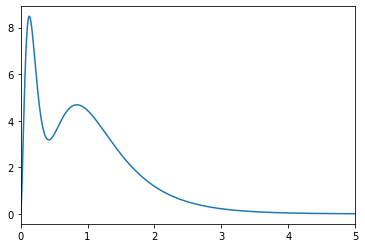

In [83]:
R = linspace(1e-8,20,2**14+1)
Zatom = 8
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 3

exc = ExchangeCorrelation()
Uks = -2*ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(100):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*pi
    epot = integrate.simps(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', integrate.simps(rho*(4*pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    plot(R, U2, label='U-hartree')
    plot(R, Vxc, label='Vxc')
    plot(R, Uks, label='Uks')
    show()
    
plot(R,rho*(4*pi*R**2))
xlim([0,5])
show()